In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [4]:
### RECEIVE 10,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
# X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [5]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    hp_regularizer = hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1), kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
#     SHOULD DROPOUT BE INCLUDED??
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
#     if hp.Boolean('adam'):
#         model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                     loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
#     else:
#         model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
#                     loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [6]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_mean_squared_error', 'min'),
                     max_epochs=100,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True,
                     seed=8)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

In [7]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.15, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1141 - mean_squared_error: 0.0969 - val_loss: 0.0543 - val_mean_squared_error: 0.0306
Epoch 2/2
8500/8500 - 1s - loss: 0.0474 - mean_squared_error: 0.0193 - val_loss: 0.0423 - val_mean_squared_error: 0.0115


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.0488 - mean_squared_error: 0.0456 - val_loss: 0.0096 - val_mean_squared_error: 0.0046
Epoch 2/2
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0098 - val_loss: 0.0092 - val_mean_squared_error: 0.0037


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2166 - mean_squared_error: 0.2158 - val_loss: 0.2084 - val_mean_squared_error: 0.2076
Epoch 2/2
8500/8500 - 1s - loss: 0.2027 - mean_squared_error: 0.2018 - val_loss: 0.1935 - val_mean_squared_error: 0.1926


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0740 - mean_squared_error: 0.0738 - val_loss: 0.0123 - val_mean_squared_error: 0.0120
Epoch 2/2
8500/8500 - 1s - loss: 0.0072 - mean_squared_error: 0.0068 - val_loss: 0.0034 - val_mean_squared_error: 0.0030


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0195 - mean_squared_error: 0.0138 - val_loss: 0.0085 - val_mean_squared_error: 0.0032
Epoch 2/2
8500/8500 - 1s - loss: 0.0132 - mean_squared_error: 0.0075 - val_loss: 0.0209 - val_mean_squared_error: 0.0137


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2300 - mean_squared_error: 0.2299 - val_loss: 0.2145 - val_mean_squared_error: 0.2145
Epoch 2/2
8500/8500 - 1s - loss: 0.2080 - mean_squared_error: 0.2079 - val_loss: 0.1988 - val_mean_squared_error: 0.1987


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1978 - mean_squared_error: 0.1977 - val_loss: 0.1764 - val_mean_squared_error: 0.1763
Epoch 2/2
8500/8500 - 1s - loss: 0.1610 - mean_squared_error: 0.1608 - val_loss: 0.1413 - val_mean_squared_error: 0.1411


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0207 - mean_squared_error: 0.0161 - val_loss: 0.0071 - val_mean_squared_error: 0.0017
Epoch 2/2
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0031 - val_loss: 0.0072 - val_mean_squared_error: 0.0018


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2093 - mean_squared_error: 0.2078 - val_loss: 0.1906 - val_mean_squared_error: 0.1891
Epoch 2/2
8500/8500 - 1s - loss: 0.1781 - mean_squared_error: 0.1766 - val_loss: 0.1613 - val_mean_squared_error: 0.1598


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1947 - mean_squared_error: 0.1933 - val_loss: 0.1704 - val_mean_squared_error: 0.1690
Epoch 2/2
8500/8500 - 1s - loss: 0.1507 - mean_squared_error: 0.1492 - val_loss: 0.1286 - val_mean_squared_error: 0.1270


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2251 - mean_squared_error: 0.2137 - val_loss: 0.2100 - val_mean_squared_error: 0.1987
Epoch 2/2
8500/8500 - 1s - loss: 0.2021 - mean_squared_error: 0.1909 - val_loss: 0.1911 - val_mean_squared_error: 0.1798


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0779 - mean_squared_error: 0.0757 - val_loss: 0.0164 - val_mean_squared_error: 0.0131
Epoch 2/2
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0076 - val_loss: 0.0079 - val_mean_squared_error: 0.0035


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2272 - mean_squared_error: 0.2265 - val_loss: 0.2137 - val_mean_squared_error: 0.2130
Epoch 2/2
8500/8500 - 1s - loss: 0.2078 - mean_squared_error: 0.2070 - val_loss: 0.1992 - val_mean_squared_error: 0.1985


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1811 - mean_squared_error: 0.1739 - val_loss: 0.1298 - val_mean_squared_error: 0.1214
Epoch 2/2
8500/8500 - 1s - loss: 0.1092 - mean_squared_error: 0.0985 - val_loss: 0.0925 - val_mean_squared_error: 0.0793


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0204 - mean_squared_error: 0.0157 - val_loss: 0.0069 - val_mean_squared_error: 0.0016
Epoch 2/2
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0028 - val_loss: 0.0073 - val_mean_squared_error: 0.0019


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0824 - mean_squared_error: 0.0797 - val_loss: 0.0210 - val_mean_squared_error: 0.0174
Epoch 2/2
8500/8500 - 1s - loss: 0.0131 - mean_squared_error: 0.0089 - val_loss: 0.0078 - val_mean_squared_error: 0.0032


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1488 - mean_squared_error: 0.1352 - val_loss: 0.1021 - val_mean_squared_error: 0.0860
Epoch 2/2
8500/8500 - 1s - loss: 0.0896 - mean_squared_error: 0.0702 - val_loss: 0.0723 - val_mean_squared_error: 0.0500


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1270 - mean_squared_error: 0.1119 - val_loss: 0.0643 - val_mean_squared_error: 0.0437
Epoch 2/2
8500/8500 - 1s - loss: 0.0521 - mean_squared_error: 0.0267 - val_loss: 0.0433 - val_mean_squared_error: 0.0142


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1363 - mean_squared_error: 0.1362 - val_loss: 0.0701 - val_mean_squared_error: 0.0699
Epoch 2/2
8500/8500 - 1s - loss: 0.0458 - mean_squared_error: 0.0456 - val_loss: 0.0219 - val_mean_squared_error: 0.0216


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2109 - mean_squared_error: 0.1897 - val_loss: 0.1837 - val_mean_squared_error: 0.1625
Epoch 2/2
8500/8500 - 1s - loss: 0.1600 - mean_squared_error: 0.1383 - val_loss: 0.1364 - val_mean_squared_error: 0.1140


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0210 - mean_squared_error: 0.0205 - val_loss: 0.0039 - val_mean_squared_error: 0.0033
Epoch 2/2
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0069 - val_loss: 0.0061 - val_mean_squared_error: 0.0054


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0243 - mean_squared_error: 0.0195 - val_loss: 0.0094 - val_mean_squared_error: 0.0043
Epoch 2/2
8500/8500 - 1s - loss: 0.0134 - mean_squared_error: 0.0080 - val_loss: 0.0124 - val_mean_squared_error: 0.0068


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1837 - mean_squared_error: 0.1811 - val_loss: 0.1505 - val_mean_squared_error: 0.1478
Epoch 2/2
8500/8500 - 1s - loss: 0.1233 - mean_squared_error: 0.1206 - val_loss: 0.0966 - val_mean_squared_error: 0.0937


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0180 - mean_squared_error: 0.0175 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 2/2
8500/8500 - 1s - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0023 - val_mean_squared_error: 0.0016


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0877 - mean_squared_error: 0.0637 - val_loss: 0.0781 - val_mean_squared_error: 0.0535
Epoch 2/2
8500/8500 - 1s - loss: 0.0767 - mean_squared_error: 0.0517 - val_loss: 0.0784 - val_mean_squared_error: 0.0535


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1099 - mean_squared_error: 0.1097 - val_loss: 0.0364 - val_mean_squared_error: 0.0362
Epoch 2/2
8500/8500 - 1s - loss: 0.0197 - mean_squared_error: 0.0193 - val_loss: 0.0074 - val_mean_squared_error: 0.0071


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1249 - mean_squared_error: 0.1248 - val_loss: 0.1090 - val_mean_squared_error: 0.1089
Epoch 2/2
8500/8500 - 1s - loss: 0.1144 - mean_squared_error: 0.1142 - val_loss: 0.1092 - val_mean_squared_error: 0.1091


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0535 - mean_squared_error: 0.0187 - val_loss: 0.0409 - val_mean_squared_error: 0.0075
Epoch 2/2
8500/8500 - 1s - loss: 0.0439 - mean_squared_error: 0.0100 - val_loss: 0.0422 - val_mean_squared_error: 0.0085


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0946 - mean_squared_error: 0.0927 - val_loss: 0.0254 - val_mean_squared_error: 0.0226
Epoch 2/2
8500/8500 - 1s - loss: 0.0158 - mean_squared_error: 0.0123 - val_loss: 0.0091 - val_mean_squared_error: 0.0050


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0659 - mean_squared_error: 0.0626 - val_loss: 0.0110 - val_mean_squared_error: 0.0067
Epoch 2/2
8500/8500 - 1s - loss: 0.0116 - mean_squared_error: 0.0068 - val_loss: 0.0073 - val_mean_squared_error: 0.0024


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2005 - mean_squared_error: 0.2003 - val_loss: 0.1804 - val_mean_squared_error: 0.1802
Epoch 2/2
8500/8500 - 1s - loss: 0.1654 - mean_squared_error: 0.1652 - val_loss: 0.1472 - val_mean_squared_error: 0.1470


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2334 - mean_squared_error: 0.2229 - val_loss: 0.2154 - val_mean_squared_error: 0.2050
Epoch 2/2
8500/8500 - 1s - loss: 0.2089 - mean_squared_error: 0.1985 - val_loss: 0.1986 - val_mean_squared_error: 0.1883


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2254 - mean_squared_error: 0.2148 - val_loss: 0.2091 - val_mean_squared_error: 0.1986
Epoch 2/2
8500/8500 - 1s - loss: 0.2009 - mean_squared_error: 0.1904 - val_loss: 0.1894 - val_mean_squared_error: 0.1790


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0572 - mean_squared_error: 0.0532 - val_loss: 0.0091 - val_mean_squared_error: 0.0042
Epoch 2/2
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0033 - val_loss: 0.0069 - val_mean_squared_error: 0.0015


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0190 - mean_squared_error: 0.0142 - val_loss: 0.0070 - val_mean_squared_error: 0.0017
Epoch 2/2
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0027 - val_loss: 0.0072 - val_mean_squared_error: 0.0018


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0553 - mean_squared_error: 0.0218 - val_loss: 0.0408 - val_mean_squared_error: 0.0074
Epoch 2/2
8500/8500 - 1s - loss: 0.0446 - mean_squared_error: 0.0107 - val_loss: 0.0417 - val_mean_squared_error: 0.0081


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2199 - mean_squared_error: 0.2081 - val_loss: 0.2034 - val_mean_squared_error: 0.1917
Epoch 2/2
8500/8500 - 1s - loss: 0.1925 - mean_squared_error: 0.1808 - val_loss: 0.1793 - val_mean_squared_error: 0.1675


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2086 - mean_squared_error: 0.1787 - val_loss: 0.1730 - val_mean_squared_error: 0.1430
Epoch 2/2
8500/8500 - 1s - loss: 0.1440 - mean_squared_error: 0.1134 - val_loss: 0.1176 - val_mean_squared_error: 0.0860


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0167 - mean_squared_error: 0.0162 - val_loss: 0.0055 - val_mean_squared_error: 0.0048
Epoch 2/2
8500/8500 - 1s - loss: 0.0140 - mean_squared_error: 0.0131 - val_loss: 0.0226 - val_mean_squared_error: 0.0213


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0527 - mean_squared_error: 0.0224 - val_loss: 0.0415 - val_mean_squared_error: 0.0100
Epoch 2/2
8500/8500 - 1s - loss: 0.0433 - mean_squared_error: 0.0115 - val_loss: 0.0423 - val_mean_squared_error: 0.0108


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1028 - mean_squared_error: 0.1010 - val_loss: 0.0324 - val_mean_squared_error: 0.0298
Epoch 2/2
8500/8500 - 1s - loss: 0.0191 - mean_squared_error: 0.0158 - val_loss: 0.0100 - val_mean_squared_error: 0.0062


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0199 - mean_squared_error: 0.0147 - val_loss: 0.0079 - val_mean_squared_error: 0.0028
Epoch 2/2
8500/8500 - 1s - loss: 0.0106 - mean_squared_error: 0.0055 - val_loss: 0.0115 - val_mean_squared_error: 0.0061


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0841 - mean_squared_error: 0.0411 - val_loss: 0.0473 - val_mean_squared_error: 0.0064
Epoch 2/2
8500/8500 - 2s - loss: 0.0443 - mean_squared_error: 0.0074 - val_loss: 0.0402 - val_mean_squared_error: 0.0060


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0842 - mean_squared_error: 0.0840 - val_loss: 0.0168 - val_mean_squared_error: 0.0164
Epoch 2/2
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0089 - val_loss: 0.0041 - val_mean_squared_error: 0.0037


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2052 - mean_squared_error: 0.2050 - val_loss: 0.1873 - val_mean_squared_error: 0.1872
Epoch 2/2
8500/8500 - 1s - loss: 0.1754 - mean_squared_error: 0.1753 - val_loss: 0.1602 - val_mean_squared_error: 0.1601


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1994 - mean_squared_error: 0.1992 - val_loss: 0.1728 - val_mean_squared_error: 0.1726
Epoch 2/2
8500/8500 - 1s - loss: 0.1523 - mean_squared_error: 0.1521 - val_loss: 0.1282 - val_mean_squared_error: 0.1280


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0916 - mean_squared_error: 0.0891 - val_loss: 0.0277 - val_mean_squared_error: 0.0244
Epoch 2/2
8500/8500 - 1s - loss: 0.0214 - mean_squared_error: 0.0175 - val_loss: 0.0092 - val_mean_squared_error: 0.0049


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1793 - mean_squared_error: 0.1790 - val_loss: 0.1400 - val_mean_squared_error: 0.1397
Epoch 2/2
8500/8500 - 1s - loss: 0.1088 - mean_squared_error: 0.1085 - val_loss: 0.0806 - val_mean_squared_error: 0.0802


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1060 - mean_squared_error: 0.0780 - val_loss: 0.0495 - val_mean_squared_error: 0.0154
Epoch 2/2
8500/8500 - 1s - loss: 0.0470 - mean_squared_error: 0.0116 - val_loss: 0.0413 - val_mean_squared_error: 0.0062


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1977 - mean_squared_error: 0.1963 - val_loss: 0.1757 - val_mean_squared_error: 0.1743
Epoch 2/2
8500/8500 - 1s - loss: 0.1584 - mean_squared_error: 0.1570 - val_loss: 0.1381 - val_mean_squared_error: 0.1366


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2258 - mean_squared_error: 0.2142 - val_loss: 0.2060 - val_mean_squared_error: 0.1944
Epoch 2/2
8500/8500 - 1s - loss: 0.1965 - mean_squared_error: 0.1851 - val_loss: 0.1834 - val_mean_squared_error: 0.1718


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2240 - mean_squared_error: 0.2123 - val_loss: 0.2063 - val_mean_squared_error: 0.1947
Epoch 2/2
8500/8500 - 1s - loss: 0.1964 - mean_squared_error: 0.1848 - val_loss: 0.1832 - val_mean_squared_error: 0.1717


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2197 - mean_squared_error: 0.2186 - val_loss: 0.2034 - val_mean_squared_error: 0.2022
Epoch 2/2
8500/8500 - 1s - loss: 0.1937 - mean_squared_error: 0.1926 - val_loss: 0.1808 - val_mean_squared_error: 0.1797


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0523 - mean_squared_error: 0.0218 - val_loss: 0.0415 - val_mean_squared_error: 0.0100
Epoch 2/2
8500/8500 - 1s - loss: 0.0431 - mean_squared_error: 0.0114 - val_loss: 0.0422 - val_mean_squared_error: 0.0107


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1011 - mean_squared_error: 0.0814 - val_loss: 0.0475 - val_mean_squared_error: 0.0203
Epoch 2/2
8500/8500 - 1s - loss: 0.0444 - mean_squared_error: 0.0141 - val_loss: 0.0417 - val_mean_squared_error: 0.0101


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2017 - mean_squared_error: 0.2004 - val_loss: 0.1805 - val_mean_squared_error: 0.1791
Epoch 2/2
8500/8500 - 1s - loss: 0.1649 - mean_squared_error: 0.1635 - val_loss: 0.1464 - val_mean_squared_error: 0.1449


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0929 - mean_squared_error: 0.0927 - val_loss: 0.0237 - val_mean_squared_error: 0.0234
Epoch 2/2
8500/8500 - 1s - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0052 - val_mean_squared_error: 0.0048


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0751 - mean_squared_error: 0.0748 - val_loss: 0.0113 - val_mean_squared_error: 0.0109
Epoch 2/2
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0089 - val_loss: 0.0036 - val_mean_squared_error: 0.0032


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0222 - mean_squared_error: 0.0177 - val_loss: 0.0070 - val_mean_squared_error: 0.0017
Epoch 2/2
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0034 - val_loss: 0.0072 - val_mean_squared_error: 0.0018


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0146 - mean_squared_error: 0.0141 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 2/2
8500/8500 - 1s - loss: 0.0031 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0016


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0535 - mean_squared_error: 0.0235 - val_loss: 0.0414 - val_mean_squared_error: 0.0100
Epoch 2/2
8500/8500 - 1s - loss: 0.0434 - mean_squared_error: 0.0117 - val_loss: 0.0421 - val_mean_squared_error: 0.0107


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1934 - mean_squared_error: 0.1932 - val_loss: 0.1649 - val_mean_squared_error: 0.1647
Epoch 2/2
8500/8500 - 1s - loss: 0.1401 - mean_squared_error: 0.1399 - val_loss: 0.1131 - val_mean_squared_error: 0.1128


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2087 - mean_squared_error: 0.2074 - val_loss: 0.1885 - val_mean_squared_error: 0.1873
Epoch 2/2
8500/8500 - 1s - loss: 0.1762 - mean_squared_error: 0.1749 - val_loss: 0.1601 - val_mean_squared_error: 0.1588


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1948 - mean_squared_error: 0.1934 - val_loss: 0.1711 - val_mean_squared_error: 0.1697
Epoch 2/2
8500/8500 - 1s - loss: 0.1527 - mean_squared_error: 0.1512 - val_loss: 0.1315 - val_mean_squared_error: 0.1300


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1935 - mean_squared_error: 0.1933 - val_loss: 0.1707 - val_mean_squared_error: 0.1706
Epoch 2/2
8500/8500 - 1s - loss: 0.1519 - mean_squared_error: 0.1517 - val_loss: 0.1308 - val_mean_squared_error: 0.1306


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1868 - mean_squared_error: 0.1866 - val_loss: 0.1538 - val_mean_squared_error: 0.1535
Epoch 2/2
8500/8500 - 1s - loss: 0.1258 - mean_squared_error: 0.1255 - val_loss: 0.0958 - val_mean_squared_error: 0.0955


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0634 - mean_squared_error: 0.0361 - val_loss: 0.0413 - val_mean_squared_error: 0.0098
Epoch 2/2
8500/8500 - 1s - loss: 0.0458 - mean_squared_error: 0.0141 - val_loss: 0.0415 - val_mean_squared_error: 0.0100


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0263 - mean_squared_error: 0.0219 - val_loss: 0.0073 - val_mean_squared_error: 0.0024
Epoch 2/2
8500/8500 - 1s - loss: 0.0094 - mean_squared_error: 0.0045 - val_loss: 0.0080 - val_mean_squared_error: 0.0032


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0702 - mean_squared_error: 0.0669 - val_loss: 0.0117 - val_mean_squared_error: 0.0074
Epoch 2/2
8500/8500 - 1s - loss: 0.0102 - mean_squared_error: 0.0055 - val_loss: 0.0073 - val_mean_squared_error: 0.0024


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0252 - mean_squared_error: 0.0202 - val_loss: 0.0098 - val_mean_squared_error: 0.0044
Epoch 2/2
8500/8500 - 1s - loss: 0.0167 - mean_squared_error: 0.0107 - val_loss: 0.0163 - val_mean_squared_error: 0.0092


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0751 - mean_squared_error: 0.0478 - val_loss: 0.0438 - val_mean_squared_error: 0.0114
Epoch 2/2
8500/8500 - 1s - loss: 0.0515 - mean_squared_error: 0.0187 - val_loss: 0.0427 - val_mean_squared_error: 0.0099


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0539 - mean_squared_error: 0.0174 - val_loss: 0.0421 - val_mean_squared_error: 0.0084
Epoch 2/2
8500/8500 - 1s - loss: 0.0446 - mean_squared_error: 0.0101 - val_loss: 0.0433 - val_mean_squared_error: 0.0091


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1786 - mean_squared_error: 0.1786 - val_loss: 0.1346 - val_mean_squared_error: 0.1345
Epoch 2/2
8500/8500 - 1s - loss: 0.1153 - mean_squared_error: 0.1152 - val_loss: 0.0977 - val_mean_squared_error: 0.0976


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.0727 - mean_squared_error: 0.0482 - val_loss: 0.0413 - val_mean_squared_error: 0.0101
Epoch 2/2
8500/8500 - 1s - loss: 0.0486 - mean_squared_error: 0.0172 - val_loss: 0.0417 - val_mean_squared_error: 0.0104


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1089 - mean_squared_error: 0.0919 - val_loss: 0.0892 - val_mean_squared_error: 0.0710
Epoch 2/2
8500/8500 - 1s - loss: 0.0956 - mean_squared_error: 0.0773 - val_loss: 0.0876 - val_mean_squared_error: 0.0693


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2324 - mean_squared_error: 0.2258 - val_loss: 0.2183 - val_mean_squared_error: 0.2118
Epoch 2/2
8500/8500 - 1s - loss: 0.2135 - mean_squared_error: 0.2071 - val_loss: 0.2047 - val_mean_squared_error: 0.1984


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0905 - mean_squared_error: 0.0547 - val_loss: 0.0473 - val_mean_squared_error: 0.0079
Epoch 2/2
8500/8500 - 1s - loss: 0.0451 - mean_squared_error: 0.0078 - val_loss: 0.0413 - val_mean_squared_error: 0.0060


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0892 - mean_squared_error: 0.0890 - val_loss: 0.0207 - val_mean_squared_error: 0.0204
Epoch 2/2
8500/8500 - 1s - loss: 0.0113 - mean_squared_error: 0.0109 - val_loss: 0.0047 - val_mean_squared_error: 0.0043


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1545 - mean_squared_error: 0.1536 - val_loss: 0.0952 - val_mean_squared_error: 0.0939
Epoch 2/2
8500/8500 - 1s - loss: 0.0722 - mean_squared_error: 0.0706 - val_loss: 0.0475 - val_mean_squared_error: 0.0455


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0200 - mean_squared_error: 0.0153 - val_loss: 0.0071 - val_mean_squared_error: 0.0017
Epoch 2/2
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0029 - val_loss: 0.0071 - val_mean_squared_error: 0.0017


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2149 - mean_squared_error: 0.2015 - val_loss: 0.1941 - val_mean_squared_error: 0.1808
Epoch 2/2
8500/8500 - 1s - loss: 0.1788 - mean_squared_error: 0.1653 - val_loss: 0.1609 - val_mean_squared_error: 0.1472


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2242 - mean_squared_error: 0.2127 - val_loss: 0.2073 - val_mean_squared_error: 0.1959
Epoch 2/2
8500/8500 - 1s - loss: 0.1976 - mean_squared_error: 0.1862 - val_loss: 0.1849 - val_mean_squared_error: 0.1735


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0783 - mean_squared_error: 0.0761 - val_loss: 0.0166 - val_mean_squared_error: 0.0133
Epoch 2/2
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0076 - val_loss: 0.0079 - val_mean_squared_error: 0.0035


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0967 - mean_squared_error: 0.0636 - val_loss: 0.0481 - val_mean_squared_error: 0.0100
Epoch 2/2
8500/8500 - 1s - loss: 0.0456 - mean_squared_error: 0.0085 - val_loss: 0.0416 - val_mean_squared_error: 0.0061


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1473 - mean_squared_error: 0.1462 - val_loss: 0.0835 - val_mean_squared_error: 0.0820
Epoch 2/2
8500/8500 - 1s - loss: 0.0590 - mean_squared_error: 0.0571 - val_loss: 0.0342 - val_mean_squared_error: 0.0317


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0209 - mean_squared_error: 0.0157 - val_loss: 0.0088 - val_mean_squared_error: 0.0036
Epoch 2/2
8500/8500 - 1s - loss: 0.0131 - mean_squared_error: 0.0076 - val_loss: 0.0133 - val_mean_squared_error: 0.0073


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0542 - mean_squared_error: 0.0244 - val_loss: 0.0414 - val_mean_squared_error: 0.0099
Epoch 2/2
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0118 - val_loss: 0.0419 - val_mean_squared_error: 0.0104


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0567 - mean_squared_error: 0.0277 - val_loss: 0.0414 - val_mean_squared_error: 0.0100
Epoch 2/2
8500/8500 - 1s - loss: 0.0442 - mean_squared_error: 0.0125 - val_loss: 0.0418 - val_mean_squared_error: 0.0104


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0854 - mean_squared_error: 0.0851 - val_loss: 0.0192 - val_mean_squared_error: 0.0188
Epoch 2/2
8500/8500 - 1s - loss: 0.0121 - mean_squared_error: 0.0117 - val_loss: 0.0043 - val_mean_squared_error: 0.0038


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0572 - mean_squared_error: 0.0283 - val_loss: 0.0414 - val_mean_squared_error: 0.0098
Epoch 2/2
8500/8500 - 1s - loss: 0.0442 - mean_squared_error: 0.0125 - val_loss: 0.0418 - val_mean_squared_error: 0.0103


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0151 - mean_squared_error: 0.0143 - val_loss: 0.0124 - val_mean_squared_error: 0.0115
Epoch 2/2
8500/8500 - 2s - loss: 0.0745 - mean_squared_error: 0.0716 - val_loss: 0.1295 - val_mean_squared_error: 0.1243


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0222 - mean_squared_error: 0.0172 - val_loss: 0.0090 - val_mean_squared_error: 0.0038
Epoch 2/2
8500/8500 - 1s - loss: 0.0140 - mean_squared_error: 0.0085 - val_loss: 0.0153 - val_mean_squared_error: 0.0088


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0568 - mean_squared_error: 0.0245 - val_loss: 0.0399 - val_mean_squared_error: 0.0067
Epoch 2/2
8500/8500 - 1s - loss: 0.0437 - mean_squared_error: 0.0102 - val_loss: 0.0407 - val_mean_squared_error: 0.0073


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1210 - mean_squared_error: 0.1011 - val_loss: 0.0715 - val_mean_squared_error: 0.0468
Epoch 2/2
8500/8500 - 1s - loss: 0.0700 - mean_squared_error: 0.0424 - val_loss: 0.0539 - val_mean_squared_error: 0.0246


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1146 - mean_squared_error: 0.0973 - val_loss: 0.0541 - val_mean_squared_error: 0.0300
Epoch 2/2
8500/8500 - 1s - loss: 0.0471 - mean_squared_error: 0.0188 - val_loss: 0.0422 - val_mean_squared_error: 0.0113


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1862 - mean_squared_error: 0.1831 - val_loss: 0.1485 - val_mean_squared_error: 0.1454
Epoch 2/2
8500/8500 - 1s - loss: 0.1176 - mean_squared_error: 0.1143 - val_loss: 0.0880 - val_mean_squared_error: 0.0846


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0527 - mean_squared_error: 0.0224 - val_loss: 0.0415 - val_mean_squared_error: 0.0100
Epoch 2/2
8500/8500 - 1s - loss: 0.0431 - mean_squared_error: 0.0114 - val_loss: 0.0420 - val_mean_squared_error: 0.0106


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0813 - mean_squared_error: 0.0811 - val_loss: 0.0157 - val_mean_squared_error: 0.0154
Epoch 2/2
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0084 - val_loss: 0.0040 - val_mean_squared_error: 0.0035


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0149 - mean_squared_error: 0.0144 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 4/4
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0023 - val_loss: 0.0025 - val_mean_squared_error: 0.0018


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0175 - mean_squared_error: 0.0170 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 4/4
8500/8500 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0024


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0544 - mean_squared_error: 0.0504 - val_loss: 0.0088 - val_mean_squared_error: 0.0038
Epoch 4/4
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0032 - val_loss: 0.0068 - val_mean_squared_error: 0.0015


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0200 - mean_squared_error: 0.0153 - val_loss: 0.0070 - val_mean_squared_error: 0.0016
Epoch 4/4
8500/8500 - 1s - loss: 0.0083 - mean_squared_error: 0.0029 - val_loss: 0.0072 - val_mean_squared_error: 0.0018


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0190 - mean_squared_error: 0.0142 - val_loss: 0.0071 - val_mean_squared_error: 0.0018
Epoch 4/4
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0027 - val_loss: 0.0073 - val_mean_squared_error: 0.0019


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0223 - mean_squared_error: 0.0177 - val_loss: 0.0070 - val_mean_squared_error: 0.0017
Epoch 4/4
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0034 - val_loss: 0.0073 - val_mean_squared_error: 0.0020


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0198 - mean_squared_error: 0.0151 - val_loss: 0.0071 - val_mean_squared_error: 0.0017
Epoch 4/4
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0028 - val_loss: 0.0070 - val_mean_squared_error: 0.0017


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0206 - mean_squared_error: 0.0160 - val_loss: 0.0073 - val_mean_squared_error: 0.0020
Epoch 4/4
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0032 - val_loss: 0.0072 - val_mean_squared_error: 0.0019


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0655 - mean_squared_error: 0.0621 - val_loss: 0.0104 - val_mean_squared_error: 0.0060
Epoch 4/4
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0068 - val_loss: 0.0074 - val_mean_squared_error: 0.0024


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0732 - mean_squared_error: 0.0700 - val_loss: 0.0122 - val_mean_squared_error: 0.0080
Epoch 4/4
8500/8500 - 1s - loss: 0.0103 - mean_squared_error: 0.0057 - val_loss: 0.0073 - val_mean_squared_error: 0.0024


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0258 - mean_squared_error: 0.0214 - val_loss: 0.0071 - val_mean_squared_error: 0.0022
Epoch 4/4
8500/8500 - 1s - loss: 0.0095 - mean_squared_error: 0.0046 - val_loss: 0.0081 - val_mean_squared_error: 0.0032


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0196 - mean_squared_error: 0.0143 - val_loss: 0.0083 - val_mean_squared_error: 0.0031
Epoch 4/4
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0056 - val_loss: 0.0117 - val_mean_squared_error: 0.0063


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0751 - mean_squared_error: 0.0748 - val_loss: 0.0127 - val_mean_squared_error: 0.0124
Epoch 4/4
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0070 - val_loss: 0.0035 - val_mean_squared_error: 0.0031


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0721 - mean_squared_error: 0.0718 - val_loss: 0.0106 - val_mean_squared_error: 0.0102
Epoch 4/4
8500/8500 - 1s - loss: 0.0091 - mean_squared_error: 0.0087 - val_loss: 0.0030 - val_mean_squared_error: 0.0025


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0196 - mean_squared_error: 0.0139 - val_loss: 0.0100 - val_mean_squared_error: 0.0046
Epoch 4/4
8500/8500 - 1s - loss: 0.0237 - mean_squared_error: 0.0158 - val_loss: 0.0376 - val_mean_squared_error: 0.0241


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0762 - mean_squared_error: 0.0733 - val_loss: 0.0174 - val_mean_squared_error: 0.0136
Epoch 4/4
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0072 - val_loss: 0.0074 - val_mean_squared_error: 0.0027


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0209 - mean_squared_error: 0.0204 - val_loss: 0.0044 - val_mean_squared_error: 0.0038
Epoch 4/4
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0070 - val_loss: 0.0065 - val_mean_squared_error: 0.0059


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0837 - mean_squared_error: 0.0835 - val_loss: 0.0168 - val_mean_squared_error: 0.0165
Epoch 4/4
8500/8500 - 1s - loss: 0.0092 - mean_squared_error: 0.0089 - val_loss: 0.0041 - val_mean_squared_error: 0.0037


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0804 - mean_squared_error: 0.0782 - val_loss: 0.0174 - val_mean_squared_error: 0.0141
Epoch 4/4
8500/8500 - 1s - loss: 0.0118 - mean_squared_error: 0.0080 - val_loss: 0.0080 - val_mean_squared_error: 0.0037


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0776 - mean_squared_error: 0.0754 - val_loss: 0.0163 - val_mean_squared_error: 0.0130
Epoch 4/4
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0075 - val_loss: 0.0079 - val_mean_squared_error: 0.0035


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0210 - mean_squared_error: 0.0158 - val_loss: 0.0087 - val_mean_squared_error: 0.0035
Epoch 4/4
8500/8500 - 1s - loss: 0.0143 - mean_squared_error: 0.0085 - val_loss: 0.0148 - val_mean_squared_error: 0.0083


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0801 - mean_squared_error: 0.0799 - val_loss: 0.0155 - val_mean_squared_error: 0.0152
Epoch 4/4
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0084 - val_loss: 0.0039 - val_mean_squared_error: 0.0035


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 1s - loss: 0.0475 - mean_squared_error: 0.0442 - val_loss: 0.0087 - val_mean_squared_error: 0.0037
Epoch 4/4
8500/8500 - 1s - loss: 0.0148 - mean_squared_error: 0.0095 - val_loss: 0.0095 - val_mean_squared_error: 0.0040


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0230 - mean_squared_error: 0.0180 - val_loss: 0.0094 - val_mean_squared_error: 0.0041
Epoch 4/4
8500/8500 - 1s - loss: 0.0134 - mean_squared_error: 0.0079 - val_loss: 0.0119 - val_mean_squared_error: 0.0062


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0886 - mean_squared_error: 0.0884 - val_loss: 0.0199 - val_mean_squared_error: 0.0196
Epoch 4/4
8500/8500 - 1s - loss: 0.0123 - mean_squared_error: 0.0119 - val_loss: 0.0044 - val_mean_squared_error: 0.0040


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0922 - mean_squared_error: 0.0920 - val_loss: 0.0222 - val_mean_squared_error: 0.0220
Epoch 4/4
8500/8500 - 1s - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0049 - val_mean_squared_error: 0.0045


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0242 - mean_squared_error: 0.0194 - val_loss: 0.0090 - val_mean_squared_error: 0.0039
Epoch 4/4
8500/8500 - 1s - loss: 0.0123 - mean_squared_error: 0.0072 - val_loss: 0.0103 - val_mean_squared_error: 0.0051


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0246 - mean_squared_error: 0.0195 - val_loss: 0.0106 - val_mean_squared_error: 0.0051
Epoch 4/4
8500/8500 - 1s - loss: 0.0172 - mean_squared_error: 0.0111 - val_loss: 0.0162 - val_mean_squared_error: 0.0087


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0961 - mean_squared_error: 0.0959 - val_loss: 0.0253 - val_mean_squared_error: 0.0251
Epoch 4/4
8500/8500 - 1s - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0055 - val_mean_squared_error: 0.0051


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0163 - mean_squared_error: 0.0158 - val_loss: 0.0057 - val_mean_squared_error: 0.0050
Epoch 4/4
8500/8500 - 1s - loss: 0.0135 - mean_squared_error: 0.0127 - val_loss: 0.0192 - val_mean_squared_error: 0.0179


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0924 - mean_squared_error: 0.0900 - val_loss: 0.0281 - val_mean_squared_error: 0.0248
Epoch 4/4
8500/8500 - 1s - loss: 0.0221 - mean_squared_error: 0.0182 - val_loss: 0.0097 - val_mean_squared_error: 0.0054


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0941 - mean_squared_error: 0.0922 - val_loss: 0.0254 - val_mean_squared_error: 0.0226
Epoch 4/4
8500/8500 - 1s - loss: 0.0157 - mean_squared_error: 0.0122 - val_loss: 0.0091 - val_mean_squared_error: 0.0050


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0849 - mean_squared_error: 0.0420 - val_loss: 0.0475 - val_mean_squared_error: 0.0066
Epoch 4/4
8500/8500 - 1s - loss: 0.0443 - mean_squared_error: 0.0074 - val_loss: 0.0403 - val_mean_squared_error: 0.0060


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0180 - mean_squared_error: 0.0175 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 6/12
8500/8500 - 1s - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 7/12
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - val_loss: 0.0038 - val_mean_squared_error: 0.0031
Epoch 8/12
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - val_loss: 0.0032 - val_mean_squared_error: 0.0024
Epoch 9/12
8500/8500 - 1s - loss: 0.0046 - mean_squared_error: 0.0038 - val_loss: 0.0039 - val_mean_squared_error: 0.0032
Epoch 10/12
8500/8500 - 1s - loss: 0.0046 - mean_squared_error: 0.0039 - val_loss: 0.0031 - val_mean_squared_error: 0.0023


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0551 - mean_squared_error: 0.0511 - val_loss: 0.0088 - val_mean_squared_error: 0.0039
Epoch 6/12
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0032 - val_loss: 0.0069 - val_mean_squared_error: 0.0015
Epoch 7/12
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0022 - val_loss: 0.0064 - val_mean_squared_error: 9.5459e-04
Epoch 8/12
8500/8500 - 1s - loss: 0.0073 - mean_squared_error: 0.0020 - val_loss: 0.0062 - val_mean_squared_error: 9.5292e-04
Epoch 9/12
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0019 - val_loss: 0.0061 - val_mean_squared_error: 9.1985e-04
Epoch 10/12
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 8.9620e-04
Epoch 11/12
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0020 - val_loss: 0.0059 - val_mean_squared_error: 9.6464e-04
Epoch 12/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 - val

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0146 - mean_squared_error: 0.0141 - val_loss: 0.0017 - val_mean_squared_error: 0.0010
Epoch 6/12
8500/8500 - 1s - loss: 0.0032 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0016
Epoch 7/12
8500/8500 - 1s - loss: 0.0036 - mean_squared_error: 0.0029 - val_loss: 0.0037 - val_mean_squared_error: 0.0030
Epoch 8/12
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0032 - val_loss: 0.0038 - val_mean_squared_error: 0.0030
Epoch 9/12
8500/8500 - 1s - loss: 0.0046 - mean_squared_error: 0.0038 - val_loss: 0.0044 - val_mean_squared_error: 0.0036
Epoch 10/12
8500/8500 - 1s - loss: 0.0048 - mean_squared_error: 0.0040 - val_loss: 0.0054 - val_mean_squared_error: 0.0046


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0199 - mean_squared_error: 0.0152 - val_loss: 0.0070 - val_mean_squared_error: 0.0016
Epoch 6/12
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0028 - val_loss: 0.0072 - val_mean_squared_error: 0.0018
Epoch 7/12
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0031 - val_loss: 0.0078 - val_mean_squared_error: 0.0023
Epoch 8/12
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0032 - val_loss: 0.0075 - val_mean_squared_error: 0.0021
Epoch 9/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0035 - val_loss: 0.0086 - val_mean_squared_error: 0.0031
Epoch 10/12
8500/8500 - 1s - loss: 0.0089 - mean_squared_error: 0.0034 - val_loss: 0.0083 - val_mean_squared_error: 0.0028


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0198 - mean_squared_error: 0.0151 - val_loss: 0.0073 - val_mean_squared_error: 0.0019
Epoch 6/12
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0029 - val_loss: 0.0076 - val_mean_squared_error: 0.0022
Epoch 7/12
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0030 - val_loss: 0.0083 - val_mean_squared_error: 0.0028
Epoch 8/12
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0032 - val_loss: 0.0077 - val_mean_squared_error: 0.0022
Epoch 9/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0035 - val_loss: 0.0083 - val_mean_squared_error: 0.0028
Epoch 10/12
8500/8500 - 1s - loss: 0.0089 - mean_squared_error: 0.0033 - val_loss: 0.0081 - val_mean_squared_error: 0.0026


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0218 - mean_squared_error: 0.0173 - val_loss: 0.0074 - val_mean_squared_error: 0.0021
Epoch 6/12
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0033 - val_loss: 0.0072 - val_mean_squared_error: 0.0019
Epoch 7/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0035 - val_loss: 0.0074 - val_mean_squared_error: 0.0020
Epoch 8/12
8500/8500 - 1s - loss: 0.0091 - mean_squared_error: 0.0036 - val_loss: 0.0075 - val_mean_squared_error: 0.0021
Epoch 9/12
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0038 - val_loss: 0.0080 - val_mean_squared_error: 0.0025
Epoch 10/12
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0038 - val_loss: 0.0085 - val_mean_squared_error: 0.0029
Epoch 11/12
8500/8500 - 1s - loss: 0.0095 - mean_squared_error: 0.0040 - val_loss: 0.0089 - val_mean_squared_error: 0.0034


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0192 - mean_squared_error: 0.0144 - val_loss: 0.0070 - val_mean_squared_error: 0.0017
Epoch 6/12
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0027 - val_loss: 0.0073 - val_mean_squared_error: 0.0019
Epoch 7/12
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0029 - val_loss: 0.0079 - val_mean_squared_error: 0.0025
Epoch 8/12
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0031 - val_loss: 0.0080 - val_mean_squared_error: 0.0025
Epoch 9/12
8500/8500 - 1s - loss: 0.0089 - mean_squared_error: 0.0033 - val_loss: 0.0087 - val_mean_squared_error: 0.0032
Epoch 10/12
8500/8500 - 1s - loss: 0.0089 - mean_squared_error: 0.0033 - val_loss: 0.0079 - val_mean_squared_error: 0.0024


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0208 - mean_squared_error: 0.0162 - val_loss: 0.0072 - val_mean_squared_error: 0.0019
Epoch 6/12
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0031 - val_loss: 0.0073 - val_mean_squared_error: 0.0019
Epoch 7/12
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0033 - val_loss: 0.0076 - val_mean_squared_error: 0.0022
Epoch 8/12
8500/8500 - 1s - loss: 0.0089 - mean_squared_error: 0.0034 - val_loss: 0.0078 - val_mean_squared_error: 0.0023
Epoch 9/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0035 - val_loss: 0.0084 - val_mean_squared_error: 0.0029
Epoch 10/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0035 - val_loss: 0.0082 - val_mean_squared_error: 0.0027


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0300 - mean_squared_error: 0.0256 - val_loss: 0.0075 - val_mean_squared_error: 0.0025
Epoch 6/12
8500/8500 - 1s - loss: 0.0091 - mean_squared_error: 0.0042 - val_loss: 0.0087 - val_mean_squared_error: 0.0038
Epoch 7/12
8500/8500 - 1s - loss: 0.0094 - mean_squared_error: 0.0046 - val_loss: 0.0085 - val_mean_squared_error: 0.0036
Epoch 8/12
8500/8500 - 1s - loss: 0.0102 - mean_squared_error: 0.0053 - val_loss: 0.0083 - val_mean_squared_error: 0.0035
Epoch 9/12
8500/8500 - 1s - loss: 0.0104 - mean_squared_error: 0.0055 - val_loss: 0.0095 - val_mean_squared_error: 0.0045
Epoch 10/12
8500/8500 - 1s - loss: 0.0105 - mean_squared_error: 0.0056 - val_loss: 0.0088 - val_mean_squared_error: 0.0039


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0676 - mean_squared_error: 0.0643 - val_loss: 0.0110 - val_mean_squared_error: 0.0066
Epoch 6/12
8500/8500 - 1s - loss: 0.0117 - mean_squared_error: 0.0069 - val_loss: 0.0080 - val_mean_squared_error: 0.0030
Epoch 7/12
8500/8500 - 1s - loss: 0.0102 - mean_squared_error: 0.0052 - val_loss: 0.0074 - val_mean_squared_error: 0.0023
Epoch 8/12
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0050 - val_loss: 0.0064 - val_mean_squared_error: 0.0013
Epoch 9/12
8500/8500 - 1s - loss: 0.0099 - mean_squared_error: 0.0049 - val_loss: 0.0081 - val_mean_squared_error: 0.0031
Epoch 10/12
8500/8500 - 1s - loss: 0.0097 - mean_squared_error: 0.0048 - val_loss: 0.0072 - val_mean_squared_error: 0.0023
Epoch 11/12
8500/8500 - 1s - loss: 0.0096 - mean_squared_error: 0.0048 - val_loss: 0.0070 - val_mean_squared_error: 0.0022
Epoch 12/12
8500/8500 - 1s - loss: 0.0095 - mean_squared_error: 0.0047 - val_loss: 0.0066 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0728 - mean_squared_error: 0.0696 - val_loss: 0.0130 - val_mean_squared_error: 0.0087
Epoch 6/12
8500/8500 - 1s - loss: 0.0105 - mean_squared_error: 0.0059 - val_loss: 0.0075 - val_mean_squared_error: 0.0026
Epoch 7/12
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0034 - val_loss: 0.0065 - val_mean_squared_error: 0.0014
Epoch 8/12
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0030 - val_loss: 0.0062 - val_mean_squared_error: 0.0011
Epoch 9/12
8500/8500 - 1s - loss: 0.0080 - mean_squared_error: 0.0029 - val_loss: 0.0065 - val_mean_squared_error: 0.0015
Epoch 10/12
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0028 - val_loss: 0.0064 - val_mean_squared_error: 0.0014
Epoch 11/12
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0028 - val_loss: 0.0060 - val_mean_squared_error: 0.0011
Epoch 12/12
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0028 - val_loss: 0.0060 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0555 - mean_squared_error: 0.0515 - val_loss: 0.0089 - val_mean_squared_error: 0.0039
Epoch 14/34
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0033 - val_loss: 0.0068 - val_mean_squared_error: 0.0014
Epoch 15/34
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0022 - val_loss: 0.0065 - val_mean_squared_error: 0.0010
Epoch 16/34
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0020 - val_loss: 0.0063 - val_mean_squared_error: 9.9764e-04
Epoch 17/34
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0019 - val_loss: 0.0060 - val_mean_squared_error: 8.9623e-04
Epoch 18/34
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0019 - val_loss: 0.0060 - val_mean_squared_error: 9.7969e-04
Epoch 19/34
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0020 - val_loss: 0.0059 - val_mean_squared_error: 0.0010
Epoch 20/34
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 - val_lo

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0147 - mean_squared_error: 0.0141 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 14/34
8500/8500 - 1s - loss: 0.0032 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 15/34
8500/8500 - 1s - loss: 0.0034 - mean_squared_error: 0.0027 - val_loss: 0.0040 - val_mean_squared_error: 0.0033
Epoch 16/34
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0033 - val_loss: 0.0036 - val_mean_squared_error: 0.0028
Epoch 17/34
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - val_loss: 0.0041 - val_mean_squared_error: 0.0033
Epoch 18/34
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0037 - val_loss: 0.0043 - val_mean_squared_error: 0.0035


Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0726 - mean_squared_error: 0.0693 - val_loss: 0.0131 - val_mean_squared_error: 0.0089
Epoch 14/34
8500/8500 - 1s - loss: 0.0106 - mean_squared_error: 0.0060 - val_loss: 0.0074 - val_mean_squared_error: 0.0024
Epoch 15/34
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0034 - val_loss: 0.0067 - val_mean_squared_error: 0.0016
Epoch 16/34
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0030 - val_loss: 0.0063 - val_mean_squared_error: 0.0012
Epoch 17/34
8500/8500 - 1s - loss: 0.0080 - mean_squared_error: 0.0029 - val_loss: 0.0063 - val_mean_squared_error: 0.0013
Epoch 18/34
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0028 - val_loss: 0.0063 - val_mean_squared_error: 0.0013
Epoch 19/34
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0028 - val_loss: 0.0064 - val_mean_squared_error: 0.0015
Epoch 20/34
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0028 - val_loss: 0.0059 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0180 - mean_squared_error: 0.0175 - val_loss: 0.0021 - val_mean_squared_error: 0.0015
Epoch 14/34
8500/8500 - 1s - loss: 0.0039 - mean_squared_error: 0.0032 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 15/34
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 16/34
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - val_loss: 0.0030 - val_mean_squared_error: 0.0022
Epoch 17/34
8500/8500 - 1s - loss: 0.0044 - mean_squared_error: 0.0036 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 18/34
8500/8500 - 1s - loss: 0.0046 - mean_squared_error: 0.0038 - val_loss: 0.0032 - val_mean_squared_error: 0.0025


Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0561 - mean_squared_error: 0.0521 - val_loss: 0.0089 - val_mean_squared_error: 0.0039
Epoch 36/100
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0032 - val_loss: 0.0068 - val_mean_squared_error: 0.0014
Epoch 37/100
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0022 - val_loss: 0.0065 - val_mean_squared_error: 0.0011
Epoch 38/100
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0020 - val_loss: 0.0063 - val_mean_squared_error: 9.6938e-04
Epoch 39/100
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0019 - val_loss: 0.0060 - val_mean_squared_error: 8.4989e-04
Epoch 40/100
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 9.0786e-04
Epoch 41/100
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0019 - val_loss: 0.0058 - val_mean_squared_error: 8.7171e-04
Epoch 42/100
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0724 - mean_squared_error: 0.0692 - val_loss: 0.0128 - val_mean_squared_error: 0.0086
Epoch 36/100
8500/8500 - 1s - loss: 0.0105 - mean_squared_error: 0.0058 - val_loss: 0.0073 - val_mean_squared_error: 0.0024
Epoch 37/100
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0035 - val_loss: 0.0065 - val_mean_squared_error: 0.0015
Epoch 38/100
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0030 - val_loss: 0.0064 - val_mean_squared_error: 0.0013
Epoch 39/100
8500/8500 - 1s - loss: 0.0080 - mean_squared_error: 0.0029 - val_loss: 0.0066 - val_mean_squared_error: 0.0015
Epoch 40/100
8500/8500 - 1s - loss: 0.0079 - mean_squared_error: 0.0029 - val_loss: 0.0061 - val_mean_squared_error: 0.0012
Epoch 41/100
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0028 - val_loss: 0.0061 - val_mean_squared_error: 0.0012
Epoch 42/100
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0028 - val_loss: 

Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1120 - mean_squared_error: 0.1118 - val_loss: 0.0500 - val_mean_squared_error: 0.0498
Epoch 2/4
8500/8500 - 1s - loss: 0.0334 - mean_squared_error: 0.0330 - val_loss: 0.0126 - val_mean_squared_error: 0.0122
Epoch 3/4
8500/8500 - 1s - loss: 0.0148 - mean_squared_error: 0.0144 - val_loss: 0.0056 - val_mean_squared_error: 0.0051
Epoch 4/4
8500/8500 - 1s - loss: 0.0104 - mean_squared_error: 0.0100 - val_loss: 0.0036 - val_mean_squared_error: 0.0031


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0198 - mean_squared_error: 0.0145 - val_loss: 0.0081 - val_mean_squared_error: 0.0029
Epoch 2/4
8500/8500 - 1s - loss: 0.0124 - mean_squared_error: 0.0070 - val_loss: 0.0156 - val_mean_squared_error: 0.0092
Epoch 3/4
8500/8500 - 1s - loss: 0.0307 - mean_squared_error: 0.0196 - val_loss: 0.0295 - val_mean_squared_error: 0.0150
Epoch 4/4
8500/8500 - 1s - loss: 0.0335 - mean_squared_error: 0.0177 - val_loss: 0.0306 - val_mean_squared_error: 0.0141


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2089 - mean_squared_error: 0.1770 - val_loss: 0.1703 - val_mean_squared_error: 0.1384
Epoch 2/4
8500/8500 - 1s - loss: 0.1414 - mean_squared_error: 0.1088 - val_loss: 0.1155 - val_mean_squared_error: 0.0820
Epoch 3/4
8500/8500 - 1s - loss: 0.1020 - mean_squared_error: 0.0676 - val_loss: 0.0884 - val_mean_squared_error: 0.0531
Epoch 4/4
8500/8500 - 1s - loss: 0.0805 - mean_squared_error: 0.0442 - val_loss: 0.0712 - val_mean_squared_error: 0.0341


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.1120 - mean_squared_error: 0.1119 - val_loss: 0.0842 - val_mean_squared_error: 0.0840
Epoch 2/4
8500/8500 - 1s - loss: 0.0907 - mean_squared_error: 0.0904 - val_loss: 0.0832 - val_mean_squared_error: 0.0830
Epoch 3/4
8500/8500 - 1s - loss: 0.0898 - mean_squared_error: 0.0896 - val_loss: 0.0847 - val_mean_squared_error: 0.0845
Epoch 4/4
8500/8500 - 1s - loss: 0.0892 - mean_squared_error: 0.0890 - val_loss: 0.0835 - val_mean_squared_error: 0.0833


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0863 - mean_squared_error: 0.0460 - val_loss: 0.0475 - val_mean_squared_error: 0.0068
Epoch 2/4
8500/8500 - 1s - loss: 0.0448 - mean_squared_error: 0.0076 - val_loss: 0.0406 - val_mean_squared_error: 0.0060
Epoch 3/4
8500/8500 - 1s - loss: 0.0411 - mean_squared_error: 0.0074 - val_loss: 0.0390 - val_mean_squared_error: 0.0059
Epoch 4/4
8500/8500 - 1s - loss: 0.0403 - mean_squared_error: 0.0074 - val_loss: 0.0387 - val_mean_squared_error: 0.0059


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.2272 - mean_squared_error: 0.2197 - val_loss: 0.2134 - val_mean_squared_error: 0.2060
Epoch 2/4
8500/8500 - 1s - loss: 0.2085 - mean_squared_error: 0.2012 - val_loss: 0.1999 - val_mean_squared_error: 0.1926
Epoch 3/4
8500/8500 - 1s - loss: 0.1960 - mean_squared_error: 0.1887 - val_loss: 0.1882 - val_mean_squared_error: 0.1809
Epoch 4/4
8500/8500 - 1s - loss: 0.1843 - mean_squared_error: 0.1770 - val_loss: 0.1768 - val_mean_squared_error: 0.1695


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0162 - mean_squared_error: 0.0154 - val_loss: 0.0105 - val_mean_squared_error: 0.0096
Epoch 2/4
8500/8500 - 1s - loss: 0.0487 - mean_squared_error: 0.0465 - val_loss: 0.0887 - val_mean_squared_error: 0.0845
Epoch 3/4
8500/8500 - 1s - loss: 0.1168 - mean_squared_error: 0.1106 - val_loss: 0.1315 - val_mean_squared_error: 0.1236
Epoch 4/4
8500/8500 - 1s - loss: 0.1418 - mean_squared_error: 0.1323 - val_loss: 0.1498 - val_mean_squared_error: 0.1388


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0823 - mean_squared_error: 0.0795 - val_loss: 0.0187 - val_mean_squared_error: 0.0150
Epoch 2/4
8500/8500 - 1s - loss: 0.0125 - mean_squared_error: 0.0083 - val_loss: 0.0075 - val_mean_squared_error: 0.0029
Epoch 3/4
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0037 - val_loss: 0.0063 - val_mean_squared_error: 0.0015
Epoch 4/4
8500/8500 - 1s - loss: 0.0079 - mean_squared_error: 0.0030 - val_loss: 0.0060 - val_mean_squared_error: 0.0011


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0954 - mean_squared_error: 0.0633 - val_loss: 0.0468 - val_mean_squared_error: 0.0096
Epoch 2/4
8500/8500 - 1s - loss: 0.0462 - mean_squared_error: 0.0097 - val_loss: 0.0411 - val_mean_squared_error: 0.0059
Epoch 3/4
8500/8500 - 1s - loss: 0.0430 - mean_squared_error: 0.0087 - val_loss: 0.0394 - val_mean_squared_error: 0.0057
Epoch 4/4
8500/8500 - 1s - loss: 0.0418 - mean_squared_error: 0.0085 - val_loss: 0.0388 - val_mean_squared_error: 0.0058


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2034 - mean_squared_error: 0.2032 - val_loss: 0.1844 - val_mean_squared_error: 0.1843
Epoch 2/4
8500/8500 - 1s - loss: 0.1717 - mean_squared_error: 0.1715 - val_loss: 0.1549 - val_mean_squared_error: 0.1547
Epoch 3/4
8500/8500 - 1s - loss: 0.1428 - mean_squared_error: 0.1427 - val_loss: 0.1262 - val_mean_squared_error: 0.1261
Epoch 4/4
8500/8500 - 1s - loss: 0.1153 - mean_squared_error: 0.1151 - val_loss: 0.1005 - val_mean_squared_error: 0.1003


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.1051 - mean_squared_error: 0.0892 - val_loss: 0.0777 - val_mean_squared_error: 0.0563
Epoch 2/4
8500/8500 - 1s - loss: 0.0850 - mean_squared_error: 0.0630 - val_loss: 0.0772 - val_mean_squared_error: 0.0552
Epoch 3/4
8500/8500 - 1s - loss: 0.0840 - mean_squared_error: 0.0619 - val_loss: 0.0768 - val_mean_squared_error: 0.0546
Epoch 4/4
8500/8500 - 1s - loss: 0.0835 - mean_squared_error: 0.0612 - val_loss: 0.0774 - val_mean_squared_error: 0.0552


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1291 - mean_squared_error: 0.1275 - val_loss: 0.0899 - val_mean_squared_error: 0.0879
Epoch 2/4
8500/8500 - 1s - loss: 0.0835 - mean_squared_error: 0.0813 - val_loss: 0.0807 - val_mean_squared_error: 0.0783
Epoch 3/4
8500/8500 - 1s - loss: 0.0801 - mean_squared_error: 0.0777 - val_loss: 0.0803 - val_mean_squared_error: 0.0778
Epoch 4/4
8500/8500 - 1s - loss: 0.0793 - mean_squared_error: 0.0768 - val_loss: 0.0800 - val_mean_squared_error: 0.0775


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.1805 - mean_squared_error: 0.1742 - val_loss: 0.1352 - val_mean_squared_error: 0.1280
Epoch 2/4
8500/8500 - 1s - loss: 0.1278 - mean_squared_error: 0.1196 - val_loss: 0.1194 - val_mean_squared_error: 0.1101
Epoch 3/4
8500/8500 - 1s - loss: 0.1178 - mean_squared_error: 0.1076 - val_loss: 0.1112 - val_mean_squared_error: 0.1002
Epoch 4/4
8500/8500 - 1s - loss: 0.1129 - mean_squared_error: 0.1012 - val_loss: 0.1069 - val_mean_squared_error: 0.0948


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1642 - mean_squared_error: 0.1638 - val_loss: 0.1143 - val_mean_squared_error: 0.1138
Epoch 2/4
8500/8500 - 1s - loss: 0.0806 - mean_squared_error: 0.0801 - val_loss: 0.0538 - val_mean_squared_error: 0.0533
Epoch 3/4
8500/8500 - 2s - loss: 0.0398 - mean_squared_error: 0.0393 - val_loss: 0.0261 - val_mean_squared_error: 0.0256
Epoch 4/4
8500/8500 - 2s - loss: 0.0200 - mean_squared_error: 0.0195 - val_loss: 0.0130 - val_mean_squared_error: 0.0124


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0177 - mean_squared_error: 0.0171 - val_loss: 0.0038 - val_mean_squared_error: 0.0032
Epoch 2/4
8500/8500 - 1s - loss: 0.0055 - mean_squared_error: 0.0049 - val_loss: 0.0055 - val_mean_squared_error: 0.0049
Epoch 3/4
8500/8500 - 1s - loss: 0.0106 - mean_squared_error: 0.0098 - val_loss: 0.0179 - val_mean_squared_error: 0.0167
Epoch 4/4
8500/8500 - 1s - loss: 0.0165 - mean_squared_error: 0.0149 - val_loss: 0.0139 - val_mean_squared_error: 0.0119


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2077 - mean_squared_error: 0.1934 - val_loss: 0.1839 - val_mean_squared_error: 0.1696
Epoch 2/4
8500/8500 - 1s - loss: 0.1654 - mean_squared_error: 0.1508 - val_loss: 0.1446 - val_mean_squared_error: 0.1295
Epoch 3/4
8500/8500 - 1s - loss: 0.1287 - mean_squared_error: 0.1129 - val_loss: 0.1113 - val_mean_squared_error: 0.0947
Epoch 4/4
8500/8500 - 1s - loss: 0.1004 - mean_squared_error: 0.0830 - val_loss: 0.0884 - val_mean_squared_error: 0.0701


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0769 - mean_squared_error: 0.0738 - val_loss: 0.0143 - val_mean_squared_error: 0.0102
Epoch 2/4
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0070 - val_loss: 0.0080 - val_mean_squared_error: 0.0032
Epoch 3/4
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0041 - val_loss: 0.0065 - val_mean_squared_error: 0.0015
Epoch 4/4
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0036 - val_loss: 0.0062 - val_mean_squared_error: 0.0011


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1947 - mean_squared_error: 0.1945 - val_loss: 0.1675 - val_mean_squared_error: 0.1672
Epoch 2/4
8500/8500 - 1s - loss: 0.1442 - mean_squared_error: 0.1440 - val_loss: 0.1192 - val_mean_squared_error: 0.1189
Epoch 3/4
8500/8500 - 1s - loss: 0.1010 - mean_squared_error: 0.1007 - val_loss: 0.0839 - val_mean_squared_error: 0.0836
Epoch 4/4
8500/8500 - 1s - loss: 0.0736 - mean_squared_error: 0.0734 - val_loss: 0.0625 - val_mean_squared_error: 0.0622


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2130 - mean_squared_error: 0.1936 - val_loss: 0.1863 - val_mean_squared_error: 0.1668
Epoch 2/4
8500/8500 - 1s - loss: 0.1638 - mean_squared_error: 0.1439 - val_loss: 0.1391 - val_mean_squared_error: 0.1186
Epoch 3/4
8500/8500 - 1s - loss: 0.1245 - mean_squared_error: 0.1033 - val_loss: 0.1105 - val_mean_squared_error: 0.0886
Epoch 4/4
8500/8500 - 1s - loss: 0.1042 - mean_squared_error: 0.0816 - val_loss: 0.0943 - val_mean_squared_error: 0.0709


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1574 - mean_squared_error: 0.1448 - val_loss: 0.1051 - val_mean_squared_error: 0.0900
Epoch 2/4
8500/8500 - 1s - loss: 0.0912 - mean_squared_error: 0.0729 - val_loss: 0.0746 - val_mean_squared_error: 0.0532
Epoch 3/4
8500/8500 - 1s - loss: 0.0715 - mean_squared_error: 0.0478 - val_loss: 0.0610 - val_mean_squared_error: 0.0352
Epoch 4/4
8500/8500 - 1s - loss: 0.0636 - mean_squared_error: 0.0367 - val_loss: 0.0562 - val_mean_squared_error: 0.0283


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.0503 - mean_squared_error: 0.0471 - val_loss: 0.0100 - val_mean_squared_error: 0.0051
Epoch 2/4
8500/8500 - 1s - loss: 0.0161 - mean_squared_error: 0.0109 - val_loss: 0.0089 - val_mean_squared_error: 0.0034
Epoch 3/4
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0096 - val_loss: 0.0089 - val_mean_squared_error: 0.0034
Epoch 4/4
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0096 - val_loss: 0.0091 - val_mean_squared_error: 0.0036


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0247 - mean_squared_error: 0.0204 - val_loss: 0.0070 - val_mean_squared_error: 0.0017
Epoch 2/4
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0039 - val_loss: 0.0076 - val_mean_squared_error: 0.0022
Epoch 3/4
8500/8500 - 1s - loss: 0.0092 - mean_squared_error: 0.0038 - val_loss: 0.0076 - val_mean_squared_error: 0.0021
Epoch 4/4
8500/8500 - 1s - loss: 0.0094 - mean_squared_error: 0.0040 - val_loss: 0.0082 - val_mean_squared_error: 0.0028


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0541 - mean_squared_error: 0.0182 - val_loss: 0.0415 - val_mean_squared_error: 0.0080
Epoch 2/4
8500/8500 - 1s - loss: 0.0438 - mean_squared_error: 0.0097 - val_loss: 0.0433 - val_mean_squared_error: 0.0091
Epoch 3/4
8500/8500 - 1s - loss: 0.0451 - mean_squared_error: 0.0104 - val_loss: 0.0453 - val_mean_squared_error: 0.0106
Epoch 4/4
8500/8500 - 1s - loss: 0.0465 - mean_squared_error: 0.0113 - val_loss: 0.0436 - val_mean_squared_error: 0.0088


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0630 - mean_squared_error: 0.0595 - val_loss: 0.0100 - val_mean_squared_error: 0.0055
Epoch 2/4
8500/8500 - 1s - loss: 0.0107 - mean_squared_error: 0.0058 - val_loss: 0.0071 - val_mean_squared_error: 0.0021
Epoch 3/4
8500/8500 - 1s - loss: 0.0095 - mean_squared_error: 0.0044 - val_loss: 0.0068 - val_mean_squared_error: 0.0017
Epoch 4/4
8500/8500 - 1s - loss: 0.0094 - mean_squared_error: 0.0042 - val_loss: 0.0064 - val_mean_squared_error: 0.0012


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1068 - mean_squared_error: 0.0883 - val_loss: 0.0502 - val_mean_squared_error: 0.0247
Epoch 2/4
8500/8500 - 1s - loss: 0.0456 - mean_squared_error: 0.0163 - val_loss: 0.0419 - val_mean_squared_error: 0.0106
Epoch 3/4
8500/8500 - 1s - loss: 0.0428 - mean_squared_error: 0.0112 - val_loss: 0.0411 - val_mean_squared_error: 0.0095
Epoch 4/4
8500/8500 - 1s - loss: 0.0423 - mean_squared_error: 0.0108 - val_loss: 0.0408 - val_mean_squared_error: 0.0094


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0582 - mean_squared_error: 0.0296 - val_loss: 0.0413 - val_mean_squared_error: 0.0099
Epoch 2/4
8500/8500 - 1s - loss: 0.0447 - mean_squared_error: 0.0130 - val_loss: 0.0419 - val_mean_squared_error: 0.0104
Epoch 3/4
8500/8500 - 1s - loss: 0.0450 - mean_squared_error: 0.0131 - val_loss: 0.0419 - val_mean_squared_error: 0.0101
Epoch 4/4
8500/8500 - 1s - loss: 0.0448 - mean_squared_error: 0.0130 - val_loss: 0.0422 - val_mean_squared_error: 0.0101


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0783 - mean_squared_error: 0.0761 - val_loss: 0.0166 - val_mean_squared_error: 0.0133
Epoch 2/4
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0076 - val_loss: 0.0080 - val_mean_squared_error: 0.0036
Epoch 3/4
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0036 - val_loss: 0.0070 - val_mean_squared_error: 0.0021
Epoch 4/4
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0027 - val_loss: 0.0068 - val_mean_squared_error: 0.0016


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0321 - mean_squared_error: 0.0278 - val_loss: 0.0093 - val_mean_squared_error: 0.0042
Epoch 2/4
8500/8500 - 1s - loss: 0.0158 - mean_squared_error: 0.0106 - val_loss: 0.0112 - val_mean_squared_error: 0.0058
Epoch 3/4
8500/8500 - 1s - loss: 0.0162 - mean_squared_error: 0.0107 - val_loss: 0.0114 - val_mean_squared_error: 0.0059
Epoch 4/4
8500/8500 - 1s - loss: 0.0165 - mean_squared_error: 0.0110 - val_loss: 0.0120 - val_mean_squared_error: 0.0064


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2049 - mean_squared_error: 0.2036 - val_loss: 0.1855 - val_mean_squared_error: 0.1842
Epoch 2/4
8500/8500 - 1s - loss: 0.1725 - mean_squared_error: 0.1712 - val_loss: 0.1561 - val_mean_squared_error: 0.1548
Epoch 3/4
8500/8500 - 1s - loss: 0.1437 - mean_squared_error: 0.1424 - val_loss: 0.1275 - val_mean_squared_error: 0.1261
Epoch 4/4
8500/8500 - 1s - loss: 0.1163 - mean_squared_error: 0.1148 - val_loss: 0.1020 - val_mean_squared_error: 0.1004


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2106 - mean_squared_error: 0.1973 - val_loss: 0.1899 - val_mean_squared_error: 0.1766
Epoch 2/4
8500/8500 - 1s - loss: 0.1749 - mean_squared_error: 0.1614 - val_loss: 0.1564 - val_mean_squared_error: 0.1426
Epoch 3/4
8500/8500 - 1s - loss: 0.1426 - mean_squared_error: 0.1283 - val_loss: 0.1258 - val_mean_squared_error: 0.1110
Epoch 4/4
8500/8500 - 1s - loss: 0.1151 - mean_squared_error: 0.0995 - val_loss: 0.1022 - val_mean_squared_error: 0.0860


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2108 - mean_squared_error: 0.1807 - val_loss: 0.1741 - val_mean_squared_error: 0.1438
Epoch 2/4
8500/8500 - 1s - loss: 0.1432 - mean_squared_error: 0.1122 - val_loss: 0.1147 - val_mean_squared_error: 0.0828
Epoch 3/4
8500/8500 - 1s - loss: 0.1008 - mean_squared_error: 0.0679 - val_loss: 0.0867 - val_mean_squared_error: 0.0528
Epoch 4/4
8500/8500 - 1s - loss: 0.0796 - mean_squared_error: 0.0448 - val_loss: 0.0698 - val_mean_squared_error: 0.0341


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2174 - mean_squared_error: 0.2165 - val_loss: 0.2035 - val_mean_squared_error: 0.2025
Epoch 2/4
8500/8500 - 1s - loss: 0.1965 - mean_squared_error: 0.1956 - val_loss: 0.1869 - val_mean_squared_error: 0.1860
Epoch 3/4
8500/8500 - 1s - loss: 0.1804 - mean_squared_error: 0.1795 - val_loss: 0.1709 - val_mean_squared_error: 0.1700
Epoch 4/4
8500/8500 - 1s - loss: 0.1644 - mean_squared_error: 0.1635 - val_loss: 0.1548 - val_mean_squared_error: 0.1539


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0534 - mean_squared_error: 0.0177 - val_loss: 0.0404 - val_mean_squared_error: 0.0072
Epoch 2/4
8500/8500 - 1s - loss: 0.0432 - mean_squared_error: 0.0093 - val_loss: 0.0426 - val_mean_squared_error: 0.0087
Epoch 3/4
8500/8500 - 1s - loss: 0.0445 - mean_squared_error: 0.0100 - val_loss: 0.0451 - val_mean_squared_error: 0.0106
Epoch 4/4
8500/8500 - 1s - loss: 0.0459 - mean_squared_error: 0.0109 - val_loss: 0.0436 - val_mean_squared_error: 0.0090


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2087 - mean_squared_error: 0.1725 - val_loss: 0.1646 - val_mean_squared_error: 0.1283
Epoch 2/4
8500/8500 - 1s - loss: 0.1342 - mean_squared_error: 0.0971 - val_loss: 0.1084 - val_mean_squared_error: 0.0704
Epoch 3/4
8500/8500 - 1s - loss: 0.0953 - mean_squared_error: 0.0563 - val_loss: 0.0816 - val_mean_squared_error: 0.0416
Epoch 4/4
8500/8500 - 1s - loss: 0.0747 - mean_squared_error: 0.0338 - val_loss: 0.0663 - val_mean_squared_error: 0.0246


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.1607 - mean_squared_error: 0.1606 - val_loss: 0.1030 - val_mean_squared_error: 0.1029
Epoch 2/4
8500/8500 - 1s - loss: 0.0800 - mean_squared_error: 0.0799 - val_loss: 0.0565 - val_mean_squared_error: 0.0563
Epoch 3/4
8500/8500 - 1s - loss: 0.0474 - mean_squared_error: 0.0472 - val_loss: 0.0298 - val_mean_squared_error: 0.0296
Epoch 4/4
8500/8500 - 1s - loss: 0.0293 - mean_squared_error: 0.0290 - val_loss: 0.0156 - val_mean_squared_error: 0.0153


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2053 - mean_squared_error: 0.2051 - val_loss: 0.1908 - val_mean_squared_error: 0.1907
Epoch 2/4
8500/8500 - 1s - loss: 0.1811 - mean_squared_error: 0.1810 - val_loss: 0.1694 - val_mean_squared_error: 0.1693
Epoch 3/4
8500/8500 - 1s - loss: 0.1592 - mean_squared_error: 0.1591 - val_loss: 0.1483 - val_mean_squared_error: 0.1482
Epoch 4/4
8500/8500 - 1s - loss: 0.1395 - mean_squared_error: 0.1393 - val_loss: 0.1313 - val_mean_squared_error: 0.1312


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0537 - mean_squared_error: 0.0237 - val_loss: 0.0414 - val_mean_squared_error: 0.0100
Epoch 2/4
8500/8500 - 1s - loss: 0.0434 - mean_squared_error: 0.0117 - val_loss: 0.0419 - val_mean_squared_error: 0.0104
Epoch 3/4
8500/8500 - 1s - loss: 0.0438 - mean_squared_error: 0.0119 - val_loss: 0.0425 - val_mean_squared_error: 0.0108
Epoch 4/4
8500/8500 - 1s - loss: 0.0439 - mean_squared_error: 0.0120 - val_loss: 0.0427 - val_mean_squared_error: 0.0104


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0983 - mean_squared_error: 0.0981 - val_loss: 0.0275 - val_mean_squared_error: 0.0273
Epoch 2/4
8500/8500 - 1s - loss: 0.0147 - mean_squared_error: 0.0143 - val_loss: 0.0059 - val_mean_squared_error: 0.0055
Epoch 3/4
8500/8500 - 1s - loss: 0.0057 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0026
Epoch 4/4
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0035 - val_loss: 0.0021 - val_mean_squared_error: 0.0016


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1869 - mean_squared_error: 0.1839 - val_loss: 0.1519 - val_mean_squared_error: 0.1489
Epoch 2/4
8500/8500 - 1s - loss: 0.1227 - mean_squared_error: 0.1197 - val_loss: 0.0935 - val_mean_squared_error: 0.0903
Epoch 3/4
8500/8500 - 1s - loss: 0.0766 - mean_squared_error: 0.0732 - val_loss: 0.0603 - val_mean_squared_error: 0.0568
Epoch 4/4
8500/8500 - 1s - loss: 0.0504 - mean_squared_error: 0.0467 - val_loss: 0.0390 - val_mean_squared_error: 0.0352


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0440 - mean_squared_error: 0.0388 - val_loss: 0.0087 - val_mean_squared_error: 0.0026
Epoch 2/4
8500/8500 - 2s - loss: 0.0089 - mean_squared_error: 0.0028 - val_loss: 0.0082 - val_mean_squared_error: 0.0021
Epoch 3/4
8500/8500 - 2s - loss: 0.0082 - mean_squared_error: 0.0022 - val_loss: 0.0070 - val_mean_squared_error: 0.0012
Epoch 4/4
8500/8500 - 2s - loss: 0.0078 - mean_squared_error: 0.0022 - val_loss: 0.0065 - val_mean_squared_error: 0.0010


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1522 - mean_squared_error: 0.1512 - val_loss: 0.0898 - val_mean_squared_error: 0.0885
Epoch 2/4
8500/8500 - 1s - loss: 0.0656 - mean_squared_error: 0.0638 - val_loss: 0.0407 - val_mean_squared_error: 0.0384
Epoch 3/4
8500/8500 - 1s - loss: 0.0334 - mean_squared_error: 0.0307 - val_loss: 0.0183 - val_mean_squared_error: 0.0152
Epoch 4/4
8500/8500 - 1s - loss: 0.0197 - mean_squared_error: 0.0163 - val_loss: 0.0105 - val_mean_squared_error: 0.0067


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0434 - mean_squared_error: 0.0382 - val_loss: 0.0084 - val_mean_squared_error: 0.0024
Epoch 6/12
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0027 - val_loss: 0.0080 - val_mean_squared_error: 0.0020
Epoch 7/12
8500/8500 - 2s - loss: 0.0082 - mean_squared_error: 0.0022 - val_loss: 0.0069 - val_mean_squared_error: 0.0011
Epoch 8/12
8500/8500 - 2s - loss: 0.0078 - mean_squared_error: 0.0021 - val_loss: 0.0065 - val_mean_squared_error: 0.0011
Epoch 9/12
8500/8500 - 2s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0063 - val_mean_squared_error: 0.0011
Epoch 10/12
8500/8500 - 1s - loss: 0.0072 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0011
Epoch 11/12
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0021 - val_loss: 0.0062 - val_mean_squared_error: 0.0014
Epoch 12/12
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0021 - val_loss: 0.0058 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0844 - mean_squared_error: 0.0816 - val_loss: 0.0204 - val_mean_squared_error: 0.0168
Epoch 6/12
8500/8500 - 1s - loss: 0.0132 - mean_squared_error: 0.0090 - val_loss: 0.0077 - val_mean_squared_error: 0.0032
Epoch 7/12
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0039 - val_loss: 0.0064 - val_mean_squared_error: 0.0016
Epoch 8/12
8500/8500 - 1s - loss: 0.0080 - mean_squared_error: 0.0031 - val_loss: 0.0060 - val_mean_squared_error: 0.0011
Epoch 9/12
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0029 - val_loss: 0.0061 - val_mean_squared_error: 0.0012
Epoch 10/12
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0028 - val_loss: 0.0061 - val_mean_squared_error: 0.0012
Epoch 11/12
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0028 - val_loss: 0.0062 - val_mean_squared_error: 0.0014
Epoch 12/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0027 - val_loss: 0.0061 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0782 - mean_squared_error: 0.0751 - val_loss: 0.0149 - val_mean_squared_error: 0.0109
Epoch 6/12
8500/8500 - 1s - loss: 0.0116 - mean_squared_error: 0.0071 - val_loss: 0.0077 - val_mean_squared_error: 0.0029
Epoch 7/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0041 - val_loss: 0.0066 - val_mean_squared_error: 0.0016
Epoch 8/12
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0036 - val_loss: 0.0063 - val_mean_squared_error: 0.0012
Epoch 9/12
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0035 - val_loss: 0.0066 - val_mean_squared_error: 0.0016
Epoch 10/12
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0034 - val_loss: 0.0063 - val_mean_squared_error: 0.0014
Epoch 11/12
8500/8500 - 1s - loss: 0.0083 - mean_squared_error: 0.0034 - val_loss: 0.0067 - val_mean_squared_error: 0.0018
Epoch 12/12
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0034 - val_loss: 0.0062 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0644 - mean_squared_error: 0.0609 - val_loss: 0.0102 - val_mean_squared_error: 0.0057
Epoch 6/12
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0059 - val_loss: 0.0069 - val_mean_squared_error: 0.0018
Epoch 7/12
8500/8500 - 1s - loss: 0.0096 - mean_squared_error: 0.0044 - val_loss: 0.0072 - val_mean_squared_error: 0.0020
Epoch 8/12
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0041 - val_loss: 0.0064 - val_mean_squared_error: 0.0013
Epoch 9/12
8500/8500 - 1s - loss: 0.0092 - mean_squared_error: 0.0041 - val_loss: 0.0068 - val_mean_squared_error: 0.0017
Epoch 10/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0040 - val_loss: 0.0065 - val_mean_squared_error: 0.0016
Epoch 11/12
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0040 - val_loss: 0.0071 - val_mean_squared_error: 0.0022
Epoch 12/12
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0040 - val_loss: 0.0066 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0993 - mean_squared_error: 0.0991 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 6/12
8500/8500 - 1s - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0057 - val_mean_squared_error: 0.0053
Epoch 7/12
8500/8500 - 1s - loss: 0.0056 - mean_squared_error: 0.0052 - val_loss: 0.0031 - val_mean_squared_error: 0.0026
Epoch 8/12
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0035 - val_loss: 0.0021 - val_mean_squared_error: 0.0016
Epoch 9/12
8500/8500 - 1s - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0017 - val_mean_squared_error: 0.0012
Epoch 10/12
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_squared_error: 9.7051e-04
Epoch 11/12
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_squared_error: 8.5798e-04
Epoch 12/12
8500/8500 - 1s - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.001

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0792 - mean_squared_error: 0.0770 - val_loss: 0.0166 - val_mean_squared_error: 0.0133
Epoch 6/12
8500/8500 - 1s - loss: 0.0116 - mean_squared_error: 0.0076 - val_loss: 0.0080 - val_mean_squared_error: 0.0036
Epoch 7/12
8500/8500 - 1s - loss: 0.0083 - mean_squared_error: 0.0036 - val_loss: 0.0070 - val_mean_squared_error: 0.0021
Epoch 8/12
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0027 - val_loss: 0.0068 - val_mean_squared_error: 0.0016
Epoch 9/12
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0024 - val_loss: 0.0066 - val_mean_squared_error: 0.0014
Epoch 10/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0022 - val_loss: 0.0067 - val_mean_squared_error: 0.0014
Epoch 11/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0021 - val_loss: 0.0067 - val_mean_squared_error: 0.0013
Epoch 12/12
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0065 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0243 - mean_squared_error: 0.0199 - val_loss: 0.0071 - val_mean_squared_error: 0.0017
Epoch 6/12
8500/8500 - 1s - loss: 0.0092 - mean_squared_error: 0.0038 - val_loss: 0.0079 - val_mean_squared_error: 0.0025
Epoch 7/12
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0039 - val_loss: 0.0075 - val_mean_squared_error: 0.0021
Epoch 8/12
8500/8500 - 1s - loss: 0.0094 - mean_squared_error: 0.0040 - val_loss: 0.0083 - val_mean_squared_error: 0.0029
Epoch 9/12
8500/8500 - 1s - loss: 0.0096 - mean_squared_error: 0.0041 - val_loss: 0.0083 - val_mean_squared_error: 0.0028
Epoch 10/12
8500/8500 - 1s - loss: 0.0097 - mean_squared_error: 0.0042 - val_loss: 0.0082 - val_mean_squared_error: 0.0026


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0201 - mean_squared_error: 0.0148 - val_loss: 0.0082 - val_mean_squared_error: 0.0030
Epoch 6/12
8500/8500 - 1s - loss: 0.0118 - mean_squared_error: 0.0064 - val_loss: 0.0138 - val_mean_squared_error: 0.0082
Epoch 7/12
8500/8500 - 1s - loss: 0.0272 - mean_squared_error: 0.0182 - val_loss: 0.0341 - val_mean_squared_error: 0.0199
Epoch 8/12
8500/8500 - 1s - loss: 0.0411 - mean_squared_error: 0.0234 - val_loss: 0.0326 - val_mean_squared_error: 0.0137
Epoch 9/12
8500/8500 - 1s - loss: 0.0326 - mean_squared_error: 0.0144 - val_loss: 0.0270 - val_mean_squared_error: 0.0098
Epoch 10/12
8500/8500 - 1s - loss: 0.0270 - mean_squared_error: 0.0113 - val_loss: 0.0235 - val_mean_squared_error: 0.0092


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.1141 - mean_squared_error: 0.1139 - val_loss: 0.0513 - val_mean_squared_error: 0.0511
Epoch 6/12
8500/8500 - 1s - loss: 0.0337 - mean_squared_error: 0.0334 - val_loss: 0.0122 - val_mean_squared_error: 0.0118
Epoch 7/12
8500/8500 - 1s - loss: 0.0150 - mean_squared_error: 0.0146 - val_loss: 0.0055 - val_mean_squared_error: 0.0050
Epoch 8/12
8500/8500 - 1s - loss: 0.0104 - mean_squared_error: 0.0100 - val_loss: 0.0031 - val_mean_squared_error: 0.0026
Epoch 9/12
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0082 - val_loss: 0.0029 - val_mean_squared_error: 0.0025
Epoch 10/12
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0077 - val_loss: 0.0035 - val_mean_squared_error: 0.0030
Epoch 11/12
8500/8500 - 1s - loss: 0.0080 - mean_squared_error: 0.0076 - val_loss: 0.0035 - val_mean_squared_error: 0.0030
Epoch 12/12
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0076 - val_loss: 0.0031 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0181 - mean_squared_error: 0.0176 - val_loss: 0.0028 - val_mean_squared_error: 0.0022
Epoch 6/12
8500/8500 - 1s - loss: 0.0053 - mean_squared_error: 0.0047 - val_loss: 0.0052 - val_mean_squared_error: 0.0045
Epoch 7/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0068 - val_loss: 0.0081 - val_mean_squared_error: 0.0073
Epoch 8/12
8500/8500 - 1s - loss: 0.0137 - mean_squared_error: 0.0126 - val_loss: 0.0150 - val_mean_squared_error: 0.0134
Epoch 9/12
8500/8500 - 1s - loss: 0.0169 - mean_squared_error: 0.0148 - val_loss: 0.0143 - val_mean_squared_error: 0.0119
Epoch 10/12
8500/8500 - 1s - loss: 0.0174 - mean_squared_error: 0.0146 - val_loss: 0.0175 - val_mean_squared_error: 0.0144


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 1s - loss: 0.0516 - mean_squared_error: 0.0484 - val_loss: 0.0095 - val_mean_squared_error: 0.0046
Epoch 6/12
8500/8500 - 1s - loss: 0.0156 - mean_squared_error: 0.0104 - val_loss: 0.0089 - val_mean_squared_error: 0.0034
Epoch 7/12
8500/8500 - 1s - loss: 0.0153 - mean_squared_error: 0.0098 - val_loss: 0.0093 - val_mean_squared_error: 0.0038
Epoch 8/12
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0096 - val_loss: 0.0088 - val_mean_squared_error: 0.0033
Epoch 9/12
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0096 - val_loss: 0.0092 - val_mean_squared_error: 0.0037
Epoch 10/12
8500/8500 - 1s - loss: 0.0150 - mean_squared_error: 0.0095 - val_loss: 0.0089 - val_mean_squared_error: 0.0033
Epoch 11/12
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0096 - val_loss: 0.0087 - val_mean_squared_error: 0.0031
Epoch 12/12
8500/8500 - 1s - loss: 0.0151 - mean_squared_error: 0.0095 - val_loss: 0.0086 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0322 - mean_squared_error: 0.0280 - val_loss: 0.0095 - val_mean_squared_error: 0.0045
Epoch 6/12
8500/8500 - 1s - loss: 0.0152 - mean_squared_error: 0.0100 - val_loss: 0.0105 - val_mean_squared_error: 0.0052
Epoch 7/12
8500/8500 - 1s - loss: 0.0164 - mean_squared_error: 0.0110 - val_loss: 0.0115 - val_mean_squared_error: 0.0060
Epoch 8/12
8500/8500 - 1s - loss: 0.0170 - mean_squared_error: 0.0114 - val_loss: 0.0123 - val_mean_squared_error: 0.0066
Epoch 9/12
8500/8500 - 1s - loss: 0.0171 - mean_squared_error: 0.0114 - val_loss: 0.0119 - val_mean_squared_error: 0.0062
Epoch 10/12
8500/8500 - 1s - loss: 0.0171 - mean_squared_error: 0.0114 - val_loss: 0.0130 - val_mean_squared_error: 0.0072


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0957 - mean_squared_error: 0.0636 - val_loss: 0.0469 - val_mean_squared_error: 0.0097
Epoch 6/12
8500/8500 - 1s - loss: 0.0461 - mean_squared_error: 0.0096 - val_loss: 0.0411 - val_mean_squared_error: 0.0059
Epoch 7/12
8500/8500 - 1s - loss: 0.0429 - mean_squared_error: 0.0087 - val_loss: 0.0394 - val_mean_squared_error: 0.0058
Epoch 8/12
8500/8500 - 1s - loss: 0.0418 - mean_squared_error: 0.0085 - val_loss: 0.0388 - val_mean_squared_error: 0.0058
Epoch 9/12
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0085 - val_loss: 0.0387 - val_mean_squared_error: 0.0059
Epoch 10/12
8500/8500 - 1s - loss: 0.0414 - mean_squared_error: 0.0086 - val_loss: 0.0387 - val_mean_squared_error: 0.0058
Epoch 11/12
8500/8500 - 1s - loss: 0.0414 - mean_squared_error: 0.0086 - val_loss: 0.0387 - val_mean_squared_error: 0.0059
Epoch 12/12
8500/8500 - 1s - loss: 0.0414 - mean_squared_error: 0.0086 - val_loss: 0.0386 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0872 - mean_squared_error: 0.0472 - val_loss: 0.0470 - val_mean_squared_error: 0.0067
Epoch 6/12
8500/8500 - 1s - loss: 0.0446 - mean_squared_error: 0.0076 - val_loss: 0.0404 - val_mean_squared_error: 0.0060
Epoch 7/12
8500/8500 - 1s - loss: 0.0410 - mean_squared_error: 0.0074 - val_loss: 0.0389 - val_mean_squared_error: 0.0059
Epoch 8/12
8500/8500 - 1s - loss: 0.0402 - mean_squared_error: 0.0074 - val_loss: 0.0387 - val_mean_squared_error: 0.0059
Epoch 9/12
8500/8500 - 1s - loss: 0.0401 - mean_squared_error: 0.0074 - val_loss: 0.0386 - val_mean_squared_error: 0.0060
Epoch 10/12
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0074 - val_loss: 0.0386 - val_mean_squared_error: 0.0059
Epoch 11/12
8500/8500 - 1s - loss: 0.0401 - mean_squared_error: 0.0074 - val_loss: 0.0386 - val_mean_squared_error: 0.0060
Epoch 12/12
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0074 - val_loss: 0.0386 - val_

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0963 - mean_squared_error: 0.0962 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 14/34
8500/8500 - 1s - loss: 0.0139 - mean_squared_error: 0.0135 - val_loss: 0.0056 - val_mean_squared_error: 0.0052
Epoch 15/34
8500/8500 - 1s - loss: 0.0055 - mean_squared_error: 0.0051 - val_loss: 0.0030 - val_mean_squared_error: 0.0025
Epoch 16/34
8500/8500 - 1s - loss: 0.0039 - mean_squared_error: 0.0034 - val_loss: 0.0021 - val_mean_squared_error: 0.0015
Epoch 17/34
8500/8500 - 1s - loss: 0.0033 - mean_squared_error: 0.0028 - val_loss: 0.0018 - val_mean_squared_error: 0.0012
Epoch 18/34
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0025 - val_loss: 0.0015 - val_mean_squared_error: 9.4948e-04
Epoch 19/34
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0016 - val_mean_squared_error: 9.6852e-04
Epoch 20/34
8500/8500 - 1s - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 3s - loss: 0.0434 - mean_squared_error: 0.0382 - val_loss: 0.0084 - val_mean_squared_error: 0.0024
Epoch 14/34
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0027 - val_loss: 0.0079 - val_mean_squared_error: 0.0018
Epoch 15/34
8500/8500 - 2s - loss: 0.0082 - mean_squared_error: 0.0022 - val_loss: 0.0071 - val_mean_squared_error: 0.0013
Epoch 16/34
8500/8500 - 2s - loss: 0.0077 - mean_squared_error: 0.0021 - val_loss: 0.0064 - val_mean_squared_error: 9.5372e-04
Epoch 17/34
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0062 - val_mean_squared_error: 0.0010
Epoch 18/34
8500/8500 - 1s - loss: 0.0072 - mean_squared_error: 0.0021 - val_loss: 0.0060 - val_mean_squared_error: 0.0010
Epoch 19/34
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0021 - val_loss: 0.0059 - val_mean_squared_error: 0.0011
Epoch 20/34
8500/8500 - 2s - loss: 0.0069 - mean_squared_error: 0.0021 - val_loss: 0.00

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0839 - mean_squared_error: 0.0811 - val_loss: 0.0188 - val_mean_squared_error: 0.0152
Epoch 14/34
8500/8500 - 1s - loss: 0.0125 - mean_squared_error: 0.0083 - val_loss: 0.0074 - val_mean_squared_error: 0.0029
Epoch 15/34
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0037 - val_loss: 0.0065 - val_mean_squared_error: 0.0017
Epoch 16/34
8500/8500 - 1s - loss: 0.0079 - mean_squared_error: 0.0031 - val_loss: 0.0060 - val_mean_squared_error: 0.0011
Epoch 17/34
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0029 - val_loss: 0.0061 - val_mean_squared_error: 0.0011
Epoch 18/34
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0028 - val_loss: 0.0062 - val_mean_squared_error: 0.0013
Epoch 19/34
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0028 - val_loss: 0.0063 - val_mean_squared_error: 0.0014
Epoch 20/34
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0027 - val_loss: 0.0059 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0766 - mean_squared_error: 0.0743 - val_loss: 0.0162 - val_mean_squared_error: 0.0129
Epoch 14/34
8500/8500 - 1s - loss: 0.0114 - mean_squared_error: 0.0075 - val_loss: 0.0079 - val_mean_squared_error: 0.0035
Epoch 15/34
8500/8500 - 1s - loss: 0.0083 - mean_squared_error: 0.0036 - val_loss: 0.0070 - val_mean_squared_error: 0.0021
Epoch 16/34
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0027 - val_loss: 0.0068 - val_mean_squared_error: 0.0016
Epoch 17/34
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0024 - val_loss: 0.0067 - val_mean_squared_error: 0.0014
Epoch 18/34
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0022 - val_loss: 0.0066 - val_mean_squared_error: 0.0013
Epoch 19/34
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0067 - val_mean_squared_error: 0.0014
Epoch 20/34
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0065 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0750 - mean_squared_error: 0.0719 - val_loss: 0.0136 - val_mean_squared_error: 0.0095
Epoch 14/34
8500/8500 - 1s - loss: 0.0113 - mean_squared_error: 0.0068 - val_loss: 0.0074 - val_mean_squared_error: 0.0025
Epoch 15/34
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0041 - val_loss: 0.0069 - val_mean_squared_error: 0.0019
Epoch 16/34
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0036 - val_loss: 0.0062 - val_mean_squared_error: 0.0012
Epoch 17/34
8500/8500 - 1s - loss: 0.0085 - mean_squared_error: 0.0034 - val_loss: 0.0066 - val_mean_squared_error: 0.0016
Epoch 18/34
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0034 - val_loss: 0.0063 - val_mean_squared_error: 0.0014
Epoch 19/34
8500/8500 - 1s - loss: 0.0083 - mean_squared_error: 0.0034 - val_loss: 0.0063 - val_mean_squared_error: 0.0014
Epoch 20/34
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0034 - val_loss: 0.0062 -

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0983 - mean_squared_error: 0.0981 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 36/100
8500/8500 - 1s - loss: 0.0141 - mean_squared_error: 0.0138 - val_loss: 0.0056 - val_mean_squared_error: 0.0052
Epoch 37/100
8500/8500 - 1s - loss: 0.0056 - mean_squared_error: 0.0051 - val_loss: 0.0030 - val_mean_squared_error: 0.0025
Epoch 38/100
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0034 - val_loss: 0.0021 - val_mean_squared_error: 0.0016
Epoch 39/100
8500/8500 - 1s - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0017 - val_mean_squared_error: 0.0012
Epoch 40/100
8500/8500 - 1s - loss: 0.0031 - mean_squared_error: 0.0025 - val_loss: 0.0015 - val_mean_squared_error: 9.3087e-04
Epoch 41/100
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0016 - val_mean_squared_error: 9.9644e-04
Epoch 42/100
8500/8500 - 1s - loss: 0.0028 - mean_squared_error: 0.0022 - va

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0444 - mean_squared_error: 0.0392 - val_loss: 0.0085 - val_mean_squared_error: 0.0025
Epoch 36/100
8500/8500 - 2s - loss: 0.0088 - mean_squared_error: 0.0027 - val_loss: 0.0079 - val_mean_squared_error: 0.0018
Epoch 37/100
8500/8500 - 2s - loss: 0.0082 - mean_squared_error: 0.0022 - val_loss: 0.0069 - val_mean_squared_error: 0.0010
Epoch 38/100
8500/8500 - 2s - loss: 0.0078 - mean_squared_error: 0.0021 - val_loss: 0.0067 - val_mean_squared_error: 0.0012
Epoch 39/100
8500/8500 - 2s - loss: 0.0075 - mean_squared_error: 0.0021 - val_loss: 0.0065 - val_mean_squared_error: 0.0013
Epoch 40/100
8500/8500 - 2s - loss: 0.0072 - mean_squared_error: 0.0021 - val_loss: 0.0060 - val_mean_squared_error: 0.0010
Epoch 41/100
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0013
Epoch 42/100
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0021 - val_loss: 

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0534 - mean_squared_error: 0.0169 - val_loss: 0.0422 - val_mean_squared_error: 0.0084
Epoch 2/12
8500/8500 - 2s - loss: 0.0451 - mean_squared_error: 0.0103 - val_loss: 0.0441 - val_mean_squared_error: 0.0097
Epoch 3/12
8500/8500 - 2s - loss: 0.0465 - mean_squared_error: 0.0111 - val_loss: 0.0474 - val_mean_squared_error: 0.0115
Epoch 4/12
8500/8500 - 2s - loss: 0.0472 - mean_squared_error: 0.0115 - val_loss: 0.0429 - val_mean_squared_error: 0.0085
Epoch 5/12
8500/8500 - 2s - loss: 0.0455 - mean_squared_error: 0.0105 - val_loss: 0.0448 - val_mean_squared_error: 0.0095
Epoch 6/12
8500/8500 - 2s - loss: 0.0454 - mean_squared_error: 0.0105 - val_loss: 0.0437 - val_mean_squared_error: 0.0090


Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0994 - mean_squared_error: 0.0972 - val_loss: 0.0925 - val_mean_squared_error: 0.0902
Epoch 2/12
8500/8500 - 1s - loss: 0.0904 - mean_squared_error: 0.0880 - val_loss: 0.0919 - val_mean_squared_error: 0.0895
Epoch 3/12
8500/8500 - 1s - loss: 0.0890 - mean_squared_error: 0.0865 - val_loss: 0.0921 - val_mean_squared_error: 0.0896
Epoch 4/12
8500/8500 - 1s - loss: 0.0884 - mean_squared_error: 0.0859 - val_loss: 0.0917 - val_mean_squared_error: 0.0892
Epoch 5/12
8500/8500 - 1s - loss: 0.0882 - mean_squared_error: 0.0857 - val_loss: 0.0915 - val_mean_squared_error: 0.0889
Epoch 6/12
8500/8500 - 1s - loss: 0.0879 - mean_squared_error: 0.0853 - val_loss: 0.0907 - val_mean_squared_error: 0.0881
Epoch 7/12
8500/8500 - 1s - loss: 0.0882 - mean_squared_error: 0.0856 - val_loss: 0.0909 - val_mean_squared_error: 0.0883
Epoch 8/12
8500/8500 - 1s - loss: 0.0877 - mean_squared_error: 0.0851 - val_loss: 0.0892 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0614 - mean_squared_error: 0.0577 - val_loss: 0.0099 - val_mean_squared_error: 0.0052
Epoch 2/12
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0038 - val_loss: 0.0069 - val_mean_squared_error: 0.0017
Epoch 3/12
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0023 - val_loss: 0.0063 - val_mean_squared_error: 0.0010
Epoch 4/12
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0063 - val_mean_squared_error: 0.0011
Epoch 5/12
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0019 - val_loss: 0.0061 - val_mean_squared_error: 9.6128e-04
Epoch 6/12
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 9.0384e-04
Epoch 7/12
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0020 - val_loss: 0.0058 - val_mean_squared_error: 9.2538e-04
Epoch 8/12
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0019 - val_loss: 0.00

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.1307 - mean_squared_error: 0.1306 - val_loss: 0.0610 - val_mean_squared_error: 0.0608
Epoch 2/12
8500/8500 - 1s - loss: 0.0375 - mean_squared_error: 0.0372 - val_loss: 0.0161 - val_mean_squared_error: 0.0158
Epoch 3/12
8500/8500 - 1s - loss: 0.0134 - mean_squared_error: 0.0130 - val_loss: 0.0059 - val_mean_squared_error: 0.0055
Epoch 4/12
8500/8500 - 1s - loss: 0.0079 - mean_squared_error: 0.0074 - val_loss: 0.0035 - val_mean_squared_error: 0.0031
Epoch 5/12
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 0.0056 - val_loss: 0.0028 - val_mean_squared_error: 0.0023
Epoch 6/12
8500/8500 - 1s - loss: 0.0053 - mean_squared_error: 0.0048 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 7/12
8500/8500 - 1s - loss: 0.0050 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 8/12
8500/8500 - 1s - loss: 0.0048 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2031 - mean_squared_error: 0.2030 - val_loss: 0.1822 - val_mean_squared_error: 0.1820
Epoch 2/12
8500/8500 - 1s - loss: 0.1673 - mean_squared_error: 0.1672 - val_loss: 0.1487 - val_mean_squared_error: 0.1486
Epoch 3/12
8500/8500 - 1s - loss: 0.1342 - mean_squared_error: 0.1340 - val_loss: 0.1163 - val_mean_squared_error: 0.1161
Epoch 4/12
8500/8500 - 1s - loss: 0.1039 - mean_squared_error: 0.1037 - val_loss: 0.0889 - val_mean_squared_error: 0.0887
Epoch 5/12
8500/8500 - 1s - loss: 0.0798 - mean_squared_error: 0.0796 - val_loss: 0.0684 - val_mean_squared_error: 0.0682
Epoch 6/12
8500/8500 - 1s - loss: 0.0621 - mean_squared_error: 0.0619 - val_loss: 0.0532 - val_mean_squared_error: 0.0530
Epoch 7/12
8500/8500 - 1s - loss: 0.0486 - mean_squared_error: 0.0484 - val_loss: 0.0414 - val_mean_squared_error: 0.0412
Epoch 8/12
8500/8500 - 1s - loss: 0.0381 - mean_squared_error: 0.0379 - val_loss: 0.0320 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0522 - mean_squared_error: 0.0219 - val_loss: 0.0415 - val_mean_squared_error: 0.0100
Epoch 2/12
8500/8500 - 1s - loss: 0.0431 - mean_squared_error: 0.0114 - val_loss: 0.0424 - val_mean_squared_error: 0.0109
Epoch 3/12
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0116 - val_loss: 0.0427 - val_mean_squared_error: 0.0110
Epoch 4/12
8500/8500 - 1s - loss: 0.0437 - mean_squared_error: 0.0117 - val_loss: 0.0429 - val_mean_squared_error: 0.0106
Epoch 5/12
8500/8500 - 1s - loss: 0.0443 - mean_squared_error: 0.0120 - val_loss: 0.0425 - val_mean_squared_error: 0.0104
Epoch 6/12
8500/8500 - 1s - loss: 0.0438 - mean_squared_error: 0.0118 - val_loss: 0.0423 - val_mean_squared_error: 0.0101


Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0490 - mean_squared_error: 0.0443 - val_loss: 0.0085 - val_mean_squared_error: 0.0029
Epoch 2/12
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0030 - val_loss: 0.0076 - val_mean_squared_error: 0.0018
Epoch 3/12
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0011
Epoch 4/12
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0021 - val_loss: 0.0068 - val_mean_squared_error: 0.0013
Epoch 5/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0021 - val_loss: 0.0062 - val_mean_squared_error: 0.0010
Epoch 6/12
8500/8500 - 2s - loss: 0.0072 - mean_squared_error: 0.0021 - val_loss: 0.0060 - val_mean_squared_error: 0.0010
Epoch 7/12
8500/8500 - 2s - loss: 0.0071 - mean_squared_error: 0.0022 - val_loss: 0.0060 - val_mean_squared_error: 0.0012
Epoch 8/12
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0021 - val_loss: 0.0058 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 1s - loss: 0.1260 - mean_squared_error: 0.1251 - val_loss: 0.1075 - val_mean_squared_error: 0.1062
Epoch 2/12
8500/8500 - 1s - loss: 0.1119 - mean_squared_error: 0.1106 - val_loss: 0.1063 - val_mean_squared_error: 0.1050
Epoch 3/12
8500/8500 - 1s - loss: 0.1109 - mean_squared_error: 0.1095 - val_loss: 0.1055 - val_mean_squared_error: 0.1041
Epoch 4/12
8500/8500 - 1s - loss: 0.1100 - mean_squared_error: 0.1087 - val_loss: 0.1049 - val_mean_squared_error: 0.1035
Epoch 5/12
8500/8500 - 1s - loss: 0.1095 - mean_squared_error: 0.1081 - val_loss: 0.1046 - val_mean_squared_error: 0.1031
Epoch 6/12
8500/8500 - 1s - loss: 0.1090 - mean_squared_error: 0.1076 - val_loss: 0.1042 - val_mean_squared_error: 0.1028
Epoch 7/12
8500/8500 - 1s - loss: 0.1092 - mean_squared_error: 0.1077 - val_loss: 0.1038 - val_mean_squared_error: 0.1023
Epoch 8/12
8500/8500 - 1s - loss: 0.1089 - mean_squared_error: 0.1074 - val_loss: 0.1035 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2079 - mean_squared_error: 0.2078 - val_loss: 0.1883 - val_mean_squared_error: 0.1881
Epoch 2/12
8500/8500 - 1s - loss: 0.1771 - mean_squared_error: 0.1770 - val_loss: 0.1611 - val_mean_squared_error: 0.1610
Epoch 3/12
8500/8500 - 1s - loss: 0.1499 - mean_squared_error: 0.1498 - val_loss: 0.1341 - val_mean_squared_error: 0.1340
Epoch 4/12
8500/8500 - 1s - loss: 0.1237 - mean_squared_error: 0.1236 - val_loss: 0.1090 - val_mean_squared_error: 0.1088
Epoch 5/12
8500/8500 - 1s - loss: 0.1005 - mean_squared_error: 0.1003 - val_loss: 0.0882 - val_mean_squared_error: 0.0880
Epoch 6/12
8500/8500 - 1s - loss: 0.0818 - mean_squared_error: 0.0816 - val_loss: 0.0718 - val_mean_squared_error: 0.0716
Epoch 7/12
8500/8500 - 1s - loss: 0.0672 - mean_squared_error: 0.0670 - val_loss: 0.0588 - val_mean_squared_error: 0.0586
Epoch 8/12
8500/8500 - 1s - loss: 0.0553 - mean_squared_error: 0.0551 - val_loss: 0.0479 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0590 - mean_squared_error: 0.0305 - val_loss: 0.0413 - val_mean_squared_error: 0.0099
Epoch 2/12
8500/8500 - 1s - loss: 0.0446 - mean_squared_error: 0.0129 - val_loss: 0.0416 - val_mean_squared_error: 0.0100
Epoch 3/12
8500/8500 - 1s - loss: 0.0449 - mean_squared_error: 0.0131 - val_loss: 0.0419 - val_mean_squared_error: 0.0100
Epoch 4/12
8500/8500 - 1s - loss: 0.0450 - mean_squared_error: 0.0131 - val_loss: 0.0424 - val_mean_squared_error: 0.0103
Epoch 5/12
8500/8500 - 1s - loss: 0.0450 - mean_squared_error: 0.0131 - val_loss: 0.0428 - val_mean_squared_error: 0.0110
Epoch 6/12
8500/8500 - 1s - loss: 0.0450 - mean_squared_error: 0.0132 - val_loss: 0.0424 - val_mean_squared_error: 0.0103


Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0841 - mean_squared_error: 0.0813 - val_loss: 0.0189 - val_mean_squared_error: 0.0152
Epoch 2/12
8500/8500 - 1s - loss: 0.0150 - mean_squared_error: 0.0108 - val_loss: 0.0085 - val_mean_squared_error: 0.0039
Epoch 3/12
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0061 - val_loss: 0.0071 - val_mean_squared_error: 0.0023
Epoch 4/12
8500/8500 - 1s - loss: 0.0103 - mean_squared_error: 0.0055 - val_loss: 0.0066 - val_mean_squared_error: 0.0017
Epoch 5/12
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0052 - val_loss: 0.0072 - val_mean_squared_error: 0.0023
Epoch 6/12
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0053 - val_loss: 0.0068 - val_mean_squared_error: 0.0019
Epoch 7/12
8500/8500 - 1s - loss: 0.0100 - mean_squared_error: 0.0051 - val_loss: 0.0069 - val_mean_squared_error: 0.0021
Epoch 8/12
8500/8500 - 1s - loss: 0.0100 - mean_squared_error: 0.0052 - val_loss: 0.0066 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.1091 - mean_squared_error: 0.1089 - val_loss: 0.0370 - val_mean_squared_error: 0.0367
Epoch 2/12
8500/8500 - 1s - loss: 0.0202 - mean_squared_error: 0.0199 - val_loss: 0.0078 - val_mean_squared_error: 0.0074
Epoch 3/12
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0070 - val_loss: 0.0037 - val_mean_squared_error: 0.0032
Epoch 4/12
8500/8500 - 1s - loss: 0.0049 - mean_squared_error: 0.0044 - val_loss: 0.0025 - val_mean_squared_error: 0.0020
Epoch 5/12
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0036 - val_loss: 0.0021 - val_mean_squared_error: 0.0015
Epoch 6/12
8500/8500 - 1s - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0018 - val_mean_squared_error: 0.0012
Epoch 7/12
8500/8500 - 1s - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0016 - val_mean_squared_error: 0.0011
Epoch 8/12
8500/8500 - 1s - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0015 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2037 - mean_squared_error: 0.1895 - val_loss: 0.1808 - val_mean_squared_error: 0.1665
Epoch 2/12
8500/8500 - 1s - loss: 0.1628 - mean_squared_error: 0.1481 - val_loss: 0.1421 - val_mean_squared_error: 0.1270
Epoch 3/12
8500/8500 - 1s - loss: 0.1265 - mean_squared_error: 0.1107 - val_loss: 0.1092 - val_mean_squared_error: 0.0926
Epoch 4/12
8500/8500 - 1s - loss: 0.0985 - mean_squared_error: 0.0809 - val_loss: 0.0867 - val_mean_squared_error: 0.0681
Epoch 5/12
8500/8500 - 1s - loss: 0.0801 - mean_squared_error: 0.0605 - val_loss: 0.0722 - val_mean_squared_error: 0.0517
Epoch 6/12
8500/8500 - 1s - loss: 0.0680 - mean_squared_error: 0.0465 - val_loss: 0.0622 - val_mean_squared_error: 0.0398
Epoch 7/12
8500/8500 - 1s - loss: 0.0596 - mean_squared_error: 0.0363 - val_loss: 0.0553 - val_mean_squared_error: 0.0311
Epoch 8/12
8500/8500 - 1s - loss: 0.0538 - mean_squared_error: 0.0287 - val_loss: 0.0505 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0519 - mean_squared_error: 0.0214 - val_loss: 0.0416 - val_mean_squared_error: 0.0101
Epoch 2/12
8500/8500 - 1s - loss: 0.0432 - mean_squared_error: 0.0115 - val_loss: 0.0422 - val_mean_squared_error: 0.0106
Epoch 3/12
8500/8500 - 1s - loss: 0.0436 - mean_squared_error: 0.0117 - val_loss: 0.0428 - val_mean_squared_error: 0.0109
Epoch 4/12
8500/8500 - 1s - loss: 0.0438 - mean_squared_error: 0.0118 - val_loss: 0.0428 - val_mean_squared_error: 0.0104
Epoch 5/12
8500/8500 - 1s - loss: 0.0443 - mean_squared_error: 0.0121 - val_loss: 0.0424 - val_mean_squared_error: 0.0103
Epoch 6/12
8500/8500 - 1s - loss: 0.0439 - mean_squared_error: 0.0119 - val_loss: 0.0427 - val_mean_squared_error: 0.0105


Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0312 - mean_squared_error: 0.0269 - val_loss: 0.0083 - val_mean_squared_error: 0.0033
Epoch 2/12
8500/8500 - 1s - loss: 0.0098 - mean_squared_error: 0.0049 - val_loss: 0.0082 - val_mean_squared_error: 0.0033
Epoch 3/12
8500/8500 - 1s - loss: 0.0099 - mean_squared_error: 0.0051 - val_loss: 0.0080 - val_mean_squared_error: 0.0031
Epoch 4/12
8500/8500 - 1s - loss: 0.0105 - mean_squared_error: 0.0056 - val_loss: 0.0094 - val_mean_squared_error: 0.0045
Epoch 5/12
8500/8500 - 1s - loss: 0.0107 - mean_squared_error: 0.0058 - val_loss: 0.0085 - val_mean_squared_error: 0.0037
Epoch 6/12
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0059 - val_loss: 0.0089 - val_mean_squared_error: 0.0040
Epoch 7/12
8500/8500 - 1s - loss: 0.0114 - mean_squared_error: 0.0064 - val_loss: 0.0094 - val_mean_squared_error: 0.0044
Epoch 8/12
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0061 - val_loss: 0.0097 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0311 - mean_squared_error: 0.0271 - val_loss: 0.0077 - val_mean_squared_error: 0.0025
Epoch 2/12
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0054 - val_loss: 0.0088 - val_mean_squared_error: 0.0033
Epoch 3/12
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0053 - val_loss: 0.0084 - val_mean_squared_error: 0.0029
Epoch 4/12
8500/8500 - 1s - loss: 0.0109 - mean_squared_error: 0.0054 - val_loss: 0.0097 - val_mean_squared_error: 0.0041
Epoch 5/12
8500/8500 - 1s - loss: 0.0111 - mean_squared_error: 0.0056 - val_loss: 0.0083 - val_mean_squared_error: 0.0028
Epoch 6/12
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0055 - val_loss: 0.0078 - val_mean_squared_error: 0.0023
Epoch 7/12
8500/8500 - 1s - loss: 0.0111 - mean_squared_error: 0.0055 - val_loss: 0.0085 - val_mean_squared_error: 0.0029
Epoch 8/12
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0055 - val_loss: 0.0087 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2127 - mean_squared_error: 0.1992 - val_loss: 0.1921 - val_mean_squared_error: 0.1787
Epoch 2/12
8500/8500 - 1s - loss: 0.1764 - mean_squared_error: 0.1628 - val_loss: 0.1586 - val_mean_squared_error: 0.1447
Epoch 3/12
8500/8500 - 1s - loss: 0.1442 - mean_squared_error: 0.1299 - val_loss: 0.1278 - val_mean_squared_error: 0.1129
Epoch 4/12
8500/8500 - 1s - loss: 0.1164 - mean_squared_error: 0.1008 - val_loss: 0.1034 - val_mean_squared_error: 0.0871
Epoch 5/12
8500/8500 - 1s - loss: 0.0957 - mean_squared_error: 0.0787 - val_loss: 0.0863 - val_mean_squared_error: 0.0684
Epoch 6/12
8500/8500 - 1s - loss: 0.0812 - mean_squared_error: 0.0625 - val_loss: 0.0742 - val_mean_squared_error: 0.0546
Epoch 7/12
8500/8500 - 1s - loss: 0.0706 - mean_squared_error: 0.0502 - val_loss: 0.0651 - val_mean_squared_error: 0.0439
Epoch 8/12
8500/8500 - 1s - loss: 0.0627 - mean_squared_error: 0.0407 - val_loss: 0.0583 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.1899 - mean_squared_error: 0.1896 - val_loss: 0.1601 - val_mean_squared_error: 0.1599
Epoch 2/12
8500/8500 - 1s - loss: 0.1353 - mean_squared_error: 0.1351 - val_loss: 0.1089 - val_mean_squared_error: 0.1087
Epoch 3/12
8500/8500 - 1s - loss: 0.0918 - mean_squared_error: 0.0915 - val_loss: 0.0759 - val_mean_squared_error: 0.0756
Epoch 4/12
8500/8500 - 1s - loss: 0.0657 - mean_squared_error: 0.0654 - val_loss: 0.0542 - val_mean_squared_error: 0.0539
Epoch 5/12
8500/8500 - 1s - loss: 0.0469 - mean_squared_error: 0.0466 - val_loss: 0.0377 - val_mean_squared_error: 0.0373
Epoch 6/12
8500/8500 - 1s - loss: 0.0330 - mean_squared_error: 0.0326 - val_loss: 0.0254 - val_mean_squared_error: 0.0250
Epoch 7/12
8500/8500 - 1s - loss: 0.0228 - mean_squared_error: 0.0224 - val_loss: 0.0170 - val_mean_squared_error: 0.0166
Epoch 8/12
8500/8500 - 1s - loss: 0.0160 - mean_squared_error: 0.0156 - val_loss: 0.0114 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.1099 - mean_squared_error: 0.1097 - val_loss: 0.0377 - val_mean_squared_error: 0.0375
Epoch 14/34
8500/8500 - 1s - loss: 0.0207 - mean_squared_error: 0.0203 - val_loss: 0.0079 - val_mean_squared_error: 0.0075
Epoch 15/34
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0071 - val_loss: 0.0038 - val_mean_squared_error: 0.0034
Epoch 16/34
8500/8500 - 1s - loss: 0.0049 - mean_squared_error: 0.0044 - val_loss: 0.0025 - val_mean_squared_error: 0.0020
Epoch 17/34
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0036 - val_loss: 0.0020 - val_mean_squared_error: 0.0015
Epoch 18/34
8500/8500 - 1s - loss: 0.0037 - mean_squared_error: 0.0032 - val_loss: 0.0018 - val_mean_squared_error: 0.0012
Epoch 19/34
8500/8500 - 1s - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0017 - val_mean_squared_error: 0.0011
Epoch 20/34
8500/8500 - 1s - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0016 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 3s - loss: 0.0598 - mean_squared_error: 0.0561 - val_loss: 0.0097 - val_mean_squared_error: 0.0050
Epoch 14/34
8500/8500 - 1s - loss: 0.0087 - mean_squared_error: 0.0037 - val_loss: 0.0069 - val_mean_squared_error: 0.0016
Epoch 15/34
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0023 - val_loss: 0.0063 - val_mean_squared_error: 0.0010
Epoch 16/34
8500/8500 - 1s - loss: 0.0073 - mean_squared_error: 0.0020 - val_loss: 0.0062 - val_mean_squared_error: 9.5059e-04
Epoch 17/34
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0019 - val_loss: 0.0062 - val_mean_squared_error: 0.0011
Epoch 18/34
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 8.9357e-04
Epoch 19/34
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0020 - val_loss: 0.0059 - val_mean_squared_error: 0.0010
Epoch 20/34
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 - val_loss: 

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 3s - loss: 0.0489 - mean_squared_error: 0.0442 - val_loss: 0.0086 - val_mean_squared_error: 0.0030
Epoch 14/34
8500/8500 - 1s - loss: 0.0088 - mean_squared_error: 0.0030 - val_loss: 0.0077 - val_mean_squared_error: 0.0019
Epoch 15/34
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0023 - val_loss: 0.0069 - val_mean_squared_error: 0.0012
Epoch 16/34
8500/8500 - 2s - loss: 0.0077 - mean_squared_error: 0.0021 - val_loss: 0.0068 - val_mean_squared_error: 0.0013
Epoch 17/34
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0021 - val_loss: 0.0063 - val_mean_squared_error: 0.0010
Epoch 18/34
8500/8500 - 2s - loss: 0.0072 - mean_squared_error: 0.0021 - val_loss: 0.0060 - val_mean_squared_error: 9.5534e-04
Epoch 19/34
8500/8500 - 2s - loss: 0.0071 - mean_squared_error: 0.0021 - val_loss: 0.0060 - val_mean_squared_error: 0.0012
Epoch 20/34
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0021 - val_loss: 0.00

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.1351 - mean_squared_error: 0.1350 - val_loss: 0.0628 - val_mean_squared_error: 0.0627
Epoch 14/34
8500/8500 - 1s - loss: 0.0384 - mean_squared_error: 0.0381 - val_loss: 0.0167 - val_mean_squared_error: 0.0164
Epoch 15/34
8500/8500 - 1s - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0061 - val_mean_squared_error: 0.0057
Epoch 16/34
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0074 - val_loss: 0.0036 - val_mean_squared_error: 0.0032
Epoch 17/34
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 0.0056 - val_loss: 0.0028 - val_mean_squared_error: 0.0023
Epoch 18/34
8500/8500 - 1s - loss: 0.0054 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0018
Epoch 19/34
8500/8500 - 1s - loss: 0.0051 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0017
Epoch 20/34
8500/8500 - 1s - loss: 0.0048 - mean_squared_error: 0.0042 - val_loss: 0.0022 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0861 - mean_squared_error: 0.0834 - val_loss: 0.0197 - val_mean_squared_error: 0.0161
Epoch 14/34
8500/8500 - 1s - loss: 0.0153 - mean_squared_error: 0.0111 - val_loss: 0.0085 - val_mean_squared_error: 0.0039
Epoch 15/34
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0061 - val_loss: 0.0069 - val_mean_squared_error: 0.0021
Epoch 16/34
8500/8500 - 1s - loss: 0.0103 - mean_squared_error: 0.0055 - val_loss: 0.0064 - val_mean_squared_error: 0.0015
Epoch 17/34
8500/8500 - 1s - loss: 0.0102 - mean_squared_error: 0.0053 - val_loss: 0.0072 - val_mean_squared_error: 0.0023
Epoch 18/34
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0052 - val_loss: 0.0069 - val_mean_squared_error: 0.0021
Epoch 19/34
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0053 - val_loss: 0.0068 - val_mean_squared_error: 0.0019
Epoch 20/34
8500/8500 - 1s - loss: 0.0100 - mean_squared_error: 0.0052 - val_loss: 0.0068 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0308 - mean_squared_error: 0.0267 - val_loss: 0.0077 - val_mean_squared_error: 0.0025
Epoch 14/34
8500/8500 - 1s - loss: 0.0107 - mean_squared_error: 0.0053 - val_loss: 0.0099 - val_mean_squared_error: 0.0044
Epoch 15/34
8500/8500 - 1s - loss: 0.0108 - mean_squared_error: 0.0053 - val_loss: 0.0078 - val_mean_squared_error: 0.0023
Epoch 16/34
8500/8500 - 1s - loss: 0.0109 - mean_squared_error: 0.0054 - val_loss: 0.0091 - val_mean_squared_error: 0.0036
Epoch 17/34
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0055 - val_loss: 0.0082 - val_mean_squared_error: 0.0027
Epoch 18/34
8500/8500 - 1s - loss: 0.0109 - mean_squared_error: 0.0054 - val_loss: 0.0081 - val_mean_squared_error: 0.0025
Epoch 19/34
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0055 - val_loss: 0.0089 - val_mean_squared_error: 0.0033
Epoch 20/34
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0055 - val_loss: 0.0083 -

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.1086 - mean_squared_error: 0.1085 - val_loss: 0.0371 - val_mean_squared_error: 0.0369
Epoch 36/100
8500/8500 - 1s - loss: 0.0202 - mean_squared_error: 0.0199 - val_loss: 0.0077 - val_mean_squared_error: 0.0074
Epoch 37/100
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0070 - val_loss: 0.0037 - val_mean_squared_error: 0.0032
Epoch 38/100
8500/8500 - 1s - loss: 0.0049 - mean_squared_error: 0.0044 - val_loss: 0.0025 - val_mean_squared_error: 0.0020
Epoch 39/100
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0036 - val_loss: 0.0021 - val_mean_squared_error: 0.0015
Epoch 40/100
8500/8500 - 1s - loss: 0.0037 - mean_squared_error: 0.0032 - val_loss: 0.0018 - val_mean_squared_error: 0.0013
Epoch 41/100
8500/8500 - 1s - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0016 - val_mean_squared_error: 9.9163e-04
Epoch 42/100
8500/8500 - 1s - loss: 0.0033 - mean_squared_error: 0.0027 - val_lo

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0578 - mean_squared_error: 0.0540 - val_loss: 0.0093 - val_mean_squared_error: 0.0046
Epoch 36/100
8500/8500 - 1s - loss: 0.0086 - mean_squared_error: 0.0036 - val_loss: 0.0068 - val_mean_squared_error: 0.0016
Epoch 37/100
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0023 - val_loss: 0.0064 - val_mean_squared_error: 0.0011
Epoch 38/100
8500/8500 - 1s - loss: 0.0073 - mean_squared_error: 0.0020 - val_loss: 0.0062 - val_mean_squared_error: 9.5622e-04
Epoch 39/100
8500/8500 - 1s - loss: 0.0071 - mean_squared_error: 0.0020 - val_loss: 0.0062 - val_mean_squared_error: 0.0011
Epoch 40/100
8500/8500 - 1s - loss: 0.0069 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 9.4074e-04
Epoch 41/100
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0019 - val_loss: 0.0058 - val_mean_squared_error: 9.2660e-04
Epoch 42/100
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 3s - loss: 0.1908 - mean_squared_error: 0.1905 - val_loss: 0.1606 - val_mean_squared_error: 0.1603
Epoch 2/34
8500/8500 - 1s - loss: 0.1332 - mean_squared_error: 0.1330 - val_loss: 0.1052 - val_mean_squared_error: 0.1049
Epoch 3/34
8500/8500 - 1s - loss: 0.0875 - mean_squared_error: 0.0872 - val_loss: 0.0715 - val_mean_squared_error: 0.0711
Epoch 4/34
8500/8500 - 1s - loss: 0.0612 - mean_squared_error: 0.0609 - val_loss: 0.0495 - val_mean_squared_error: 0.0492
Epoch 5/34
8500/8500 - 1s - loss: 0.0430 - mean_squared_error: 0.0426 - val_loss: 0.0331 - val_mean_squared_error: 0.0327
Epoch 6/34
8500/8500 - 1s - loss: 0.0294 - mean_squared_error: 0.0291 - val_loss: 0.0215 - val_mean_squared_error: 0.0211
Epoch 7/34
8500/8500 - 1s - loss: 0.0205 - mean_squared_error: 0.0201 - val_loss: 0.0140 - val_mean_squared_error: 0.0136
Epoch 8/34
8500/8500 - 1s - loss: 0.0146 - mean_squared_error: 0.0142 - val_loss: 0.0094 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 3s - loss: 0.0408 - mean_squared_error: 0.0352 - val_loss: 0.0085 - val_mean_squared_error: 0.0021
Epoch 2/34
8500/8500 - 2s - loss: 0.0088 - mean_squared_error: 0.0024 - val_loss: 0.0081 - val_mean_squared_error: 0.0017
Epoch 3/34
8500/8500 - 2s - loss: 0.0081 - mean_squared_error: 0.0020 - val_loss: 0.0075 - val_mean_squared_error: 0.0015
Epoch 4/34
8500/8500 - 2s - loss: 0.0076 - mean_squared_error: 0.0019 - val_loss: 0.0068 - val_mean_squared_error: 0.0012
Epoch 5/34
8500/8500 - 2s - loss: 0.0072 - mean_squared_error: 0.0019 - val_loss: 0.0062 - val_mean_squared_error: 9.9724e-04
Epoch 6/34
8500/8500 - 2s - loss: 0.0069 - mean_squared_error: 0.0018 - val_loss: 0.0060 - val_mean_squared_error: 9.7897e-04
Epoch 7/34
8500/8500 - 2s - loss: 0.0068 - mean_squared_error: 0.0019 - val_loss: 0.0061 - val_mean_squared_error: 0.0013
Epoch 8/34
8500/8500 - 2s - loss: 0.0067 - mean_squared_error: 0.0019 - val_loss: 0.0057 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0175 - mean_squared_error: 0.0170 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 2/34
8500/8500 - 1s - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 3/34
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0033 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 4/34
8500/8500 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 5/34
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0030
Epoch 6/34
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0037 - val_loss: 0.0033 - val_mean_squared_error: 0.0026
Epoch 7/34
8500/8500 - 1s - loss: 0.0048 - mean_squared_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_error: 0.0030


Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.1253 - mean_squared_error: 0.1236 - val_loss: 0.0741 - val_mean_squared_error: 0.0720
Epoch 2/34
8500/8500 - 1s - loss: 0.0655 - mean_squared_error: 0.0630 - val_loss: 0.0478 - val_mean_squared_error: 0.0449
Epoch 3/34
8500/8500 - 1s - loss: 0.0549 - mean_squared_error: 0.0519 - val_loss: 0.0426 - val_mean_squared_error: 0.0395
Epoch 4/34
8500/8500 - 1s - loss: 0.0530 - mean_squared_error: 0.0498 - val_loss: 0.0416 - val_mean_squared_error: 0.0382
Epoch 5/34
8500/8500 - 1s - loss: 0.0527 - mean_squared_error: 0.0493 - val_loss: 0.0413 - val_mean_squared_error: 0.0379
Epoch 6/34
8500/8500 - 1s - loss: 0.0522 - mean_squared_error: 0.0488 - val_loss: 0.0414 - val_mean_squared_error: 0.0380
Epoch 7/34
8500/8500 - 1s - loss: 0.0517 - mean_squared_error: 0.0482 - val_loss: 0.0409 - val_mean_squared_error: 0.0375
Epoch 8/34
8500/8500 - 1s - loss: 0.0514 - mean_squared_error: 0.0480 - val_loss: 0.0408 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 1s - loss: 0.0968 - mean_squared_error: 0.0967 - val_loss: 0.0667 - val_mean_squared_error: 0.0664
Epoch 2/34
8500/8500 - 1s - loss: 0.0744 - mean_squared_error: 0.0741 - val_loss: 0.0656 - val_mean_squared_error: 0.0653
Epoch 3/34
8500/8500 - 1s - loss: 0.0733 - mean_squared_error: 0.0730 - val_loss: 0.0654 - val_mean_squared_error: 0.0651
Epoch 4/34
8500/8500 - 1s - loss: 0.0727 - mean_squared_error: 0.0724 - val_loss: 0.0653 - val_mean_squared_error: 0.0650
Epoch 5/34
8500/8500 - 1s - loss: 0.0725 - mean_squared_error: 0.0721 - val_loss: 0.0654 - val_mean_squared_error: 0.0650
Epoch 6/34
8500/8500 - 1s - loss: 0.0719 - mean_squared_error: 0.0716 - val_loss: 0.0648 - val_mean_squared_error: 0.0645
Epoch 7/34
8500/8500 - 1s - loss: 0.0717 - mean_squared_error: 0.0714 - val_loss: 0.0650 - val_mean_squared_error: 0.0646
Epoch 8/34
8500/8500 - 1s - loss: 0.0719 - mean_squared_error: 0.0715 - val_loss: 0.0645 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.1672 - mean_squared_error: 0.1580 - val_loss: 0.1114 - val_mean_squared_error: 0.1003
Epoch 2/34
8500/8500 - 1s - loss: 0.0911 - mean_squared_error: 0.0768 - val_loss: 0.0713 - val_mean_squared_error: 0.0535
Epoch 3/34
8500/8500 - 1s - loss: 0.0644 - mean_squared_error: 0.0434 - val_loss: 0.0516 - val_mean_squared_error: 0.0275
Epoch 4/34
8500/8500 - 1s - loss: 0.0530 - mean_squared_error: 0.0267 - val_loss: 0.0441 - val_mean_squared_error: 0.0160
Epoch 5/34
8500/8500 - 1s - loss: 0.0489 - mean_squared_error: 0.0197 - val_loss: 0.0418 - val_mean_squared_error: 0.0118
Epoch 6/34
8500/8500 - 1s - loss: 0.0475 - mean_squared_error: 0.0170 - val_loss: 0.0411 - val_mean_squared_error: 0.0103
Epoch 7/34
8500/8500 - 1s - loss: 0.0474 - mean_squared_error: 0.0164 - val_loss: 0.0409 - val_mean_squared_error: 0.0099
Epoch 8/34
8500/8500 - 1s - loss: 0.0471 - mean_squared_error: 0.0160 - val_loss: 0.0408 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0852 - mean_squared_error: 0.0433 - val_loss: 0.0472 - val_mean_squared_error: 0.0065
Epoch 2/34
8500/8500 - 1s - loss: 0.0444 - mean_squared_error: 0.0075 - val_loss: 0.0403 - val_mean_squared_error: 0.0060
Epoch 3/34
8500/8500 - 1s - loss: 0.0408 - mean_squared_error: 0.0073 - val_loss: 0.0389 - val_mean_squared_error: 0.0059
Epoch 4/34
8500/8500 - 1s - loss: 0.0401 - mean_squared_error: 0.0073 - val_loss: 0.0386 - val_mean_squared_error: 0.0059
Epoch 5/34
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0073 - val_loss: 0.0386 - val_mean_squared_error: 0.0060
Epoch 6/34
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0074 - val_loss: 0.0386 - val_mean_squared_error: 0.0059
Epoch 7/34
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0074 - val_loss: 0.0386 - val_mean_squared_error: 0.0061
Epoch 8/34
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0074 - val_loss: 0.0387 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0271 - mean_squared_error: 0.0225 - val_loss: 0.0088 - val_mean_squared_error: 0.0037
Epoch 2/34
8500/8500 - 1s - loss: 0.0125 - mean_squared_error: 0.0074 - val_loss: 0.0105 - val_mean_squared_error: 0.0054
Epoch 3/34
8500/8500 - 1s - loss: 0.0137 - mean_squared_error: 0.0084 - val_loss: 0.0107 - val_mean_squared_error: 0.0054
Epoch 4/34
8500/8500 - 1s - loss: 0.0146 - mean_squared_error: 0.0091 - val_loss: 0.0116 - val_mean_squared_error: 0.0061
Epoch 5/34
8500/8500 - 1s - loss: 0.0152 - mean_squared_error: 0.0096 - val_loss: 0.0127 - val_mean_squared_error: 0.0068
Epoch 6/34
8500/8500 - 1s - loss: 0.0165 - mean_squared_error: 0.0104 - val_loss: 0.0127 - val_mean_squared_error: 0.0065


Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.2110 - mean_squared_error: 0.1974 - val_loss: 0.1899 - val_mean_squared_error: 0.1763
Epoch 2/34
8500/8500 - 1s - loss: 0.1727 - mean_squared_error: 0.1589 - val_loss: 0.1541 - val_mean_squared_error: 0.1400
Epoch 3/34
8500/8500 - 1s - loss: 0.1389 - mean_squared_error: 0.1243 - val_loss: 0.1227 - val_mean_squared_error: 0.1074
Epoch 4/34
8500/8500 - 1s - loss: 0.1113 - mean_squared_error: 0.0953 - val_loss: 0.0993 - val_mean_squared_error: 0.0826
Epoch 5/34
8500/8500 - 1s - loss: 0.0918 - mean_squared_error: 0.0742 - val_loss: 0.0833 - val_mean_squared_error: 0.0649
Epoch 6/34
8500/8500 - 1s - loss: 0.0780 - mean_squared_error: 0.0587 - val_loss: 0.0717 - val_mean_squared_error: 0.0515
Epoch 7/34
8500/8500 - 1s - loss: 0.0681 - mean_squared_error: 0.0471 - val_loss: 0.0630 - val_mean_squared_error: 0.0411
Epoch 8/34
8500/8500 - 1s - loss: 0.0605 - mean_squared_error: 0.0378 - val_loss: 0.0564 - val_mea

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 3s - loss: 0.0410 - mean_squared_error: 0.0354 - val_loss: 0.0086 - val_mean_squared_error: 0.0023
Epoch 36/100
8500/8500 - 2s - loss: 0.0088 - mean_squared_error: 0.0024 - val_loss: 0.0081 - val_mean_squared_error: 0.0018
Epoch 37/100
8500/8500 - 2s - loss: 0.0081 - mean_squared_error: 0.0020 - val_loss: 0.0071 - val_mean_squared_error: 0.0012
Epoch 38/100
8500/8500 - 2s - loss: 0.0076 - mean_squared_error: 0.0019 - val_loss: 0.0068 - val_mean_squared_error: 0.0012
Epoch 39/100
8500/8500 - 2s - loss: 0.0073 - mean_squared_error: 0.0019 - val_loss: 0.0062 - val_mean_squared_error: 9.8741e-04
Epoch 40/100
8500/8500 - 2s - loss: 0.0070 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 9.5313e-04
Epoch 41/100
8500/8500 - 2s - loss: 0.0068 - mean_squared_error: 0.0019 - val_loss: 0.0061 - val_mean_squared_error: 0.0012
Epoch 42/100
8500/8500 - 2s - loss: 0.0067 - mean_squared_error: 0.0019 - va

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.1927 - mean_squared_error: 0.1924 - val_loss: 0.1615 - val_mean_squared_error: 0.1613
Epoch 36/100
8500/8500 - 1s - loss: 0.1353 - mean_squared_error: 0.1351 - val_loss: 0.1058 - val_mean_squared_error: 0.1055
Epoch 37/100
8500/8500 - 1s - loss: 0.0885 - mean_squared_error: 0.0882 - val_loss: 0.0713 - val_mean_squared_error: 0.0709
Epoch 38/100
8500/8500 - 1s - loss: 0.0619 - mean_squared_error: 0.0616 - val_loss: 0.0494 - val_mean_squared_error: 0.0491
Epoch 39/100
8500/8500 - 1s - loss: 0.0436 - mean_squared_error: 0.0432 - val_loss: 0.0331 - val_mean_squared_error: 0.0328
Epoch 40/100
8500/8500 - 1s - loss: 0.0302 - mean_squared_error: 0.0299 - val_loss: 0.0216 - val_mean_squared_error: 0.0213
Epoch 41/100
8500/8500 - 1s - loss: 0.0209 - mean_squared_error: 0.0205 - val_loss: 0.0142 - val_mean_squared_error: 0.0138
Epoch 42/100
8500/8500 - 1s - loss: 0.0149 - mean_squared_error: 0.0145 - val_loss: 

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0167 - mean_squared_error: 0.0162 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 36/100
8500/8500 - 1s - loss: 0.0038 - mean_squared_error: 0.0031 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 37/100
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0034 - val_loss: 0.0039 - val_mean_squared_error: 0.0032
Epoch 38/100
8500/8500 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0030
Epoch 39/100
8500/8500 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - val_loss: 0.0032 - val_mean_squared_error: 0.0025
Epoch 40/100
8500/8500 - 1s - loss: 0.0044 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0028


Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.1996 - mean_squared_error: 0.1995 - val_loss: 0.1800 - val_mean_squared_error: 0.1799
Epoch 2/100
8500/8500 - 1s - loss: 0.1657 - mean_squared_error: 0.1656 - val_loss: 0.1479 - val_mean_squared_error: 0.1477
Epoch 3/100
8500/8500 - 1s - loss: 0.1341 - mean_squared_error: 0.1339 - val_loss: 0.1170 - val_mean_squared_error: 0.1168
Epoch 4/100
8500/8500 - 1s - loss: 0.1052 - mean_squared_error: 0.1051 - val_loss: 0.0906 - val_mean_squared_error: 0.0905
Epoch 5/100
8500/8500 - 2s - loss: 0.0821 - mean_squared_error: 0.0819 - val_loss: 0.0706 - val_mean_squared_error: 0.0704
Epoch 6/100
8500/8500 - 1s - loss: 0.0645 - mean_squared_error: 0.0643 - val_loss: 0.0553 - val_mean_squared_error: 0.0551
Epoch 7/100
8500/8500 - 1s - loss: 0.0510 - mean_squared_error: 0.0507 - val_loss: 0.0435 - val_mean_squared_error: 0.0432
Epoch 8/100
8500/8500 - 1s - loss: 0.0403 - mean_squared_error: 0.0401 - val_loss: 0.0339 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2070 - mean_squared_error: 0.1693 - val_loss: 0.1618 - val_mean_squared_error: 0.1239
Epoch 2/100
8500/8500 - 1s - loss: 0.1301 - mean_squared_error: 0.0912 - val_loss: 0.1041 - val_mean_squared_error: 0.0642
Epoch 3/100
8500/8500 - 2s - loss: 0.0911 - mean_squared_error: 0.0504 - val_loss: 0.0780 - val_mean_squared_error: 0.0362
Epoch 4/100
8500/8500 - 2s - loss: 0.0719 - mean_squared_error: 0.0294 - val_loss: 0.0642 - val_mean_squared_error: 0.0209
Epoch 5/100
8500/8500 - 2s - loss: 0.0619 - mean_squared_error: 0.0183 - val_loss: 0.0572 - val_mean_squared_error: 0.0133
Epoch 6/100
8500/8500 - 1s - loss: 0.0566 - mean_squared_error: 0.0128 - val_loss: 0.0533 - val_mean_squared_error: 0.0096
Epoch 7/100
8500/8500 - 2s - loss: 0.0534 - mean_squared_error: 0.0101 - val_loss: 0.0507 - val_mean_squared_error: 0.0078
Epoch 8/100
8500/8500 - 1s - loss: 0.0511 - mean_squared_error: 0.0087 - val_loss: 0.0487 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.1290 - mean_squared_error: 0.1144 - val_loss: 0.0662 - val_mean_squared_error: 0.0463
Epoch 2/100
8500/8500 - 1s - loss: 0.0531 - mean_squared_error: 0.0283 - val_loss: 0.0436 - val_mean_squared_error: 0.0149
Epoch 3/100
8500/8500 - 1s - loss: 0.0445 - mean_squared_error: 0.0143 - val_loss: 0.0414 - val_mean_squared_error: 0.0102
Epoch 4/100
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0121 - val_loss: 0.0410 - val_mean_squared_error: 0.0095
Epoch 5/100
8500/8500 - 1s - loss: 0.0431 - mean_squared_error: 0.0117 - val_loss: 0.0408 - val_mean_squared_error: 0.0094
Epoch 6/100
8500/8500 - 1s - loss: 0.0429 - mean_squared_error: 0.0116 - val_loss: 0.0407 - val_mean_squared_error: 0.0094
Epoch 7/100
8500/8500 - 1s - loss: 0.0428 - mean_squared_error: 0.0116 - val_loss: 0.0406 - val_mean_squared_error: 0.0094
Epoch 8/100
8500/8500 - 1s - loss: 0.0428 - mean_squared_error: 0.0116 - val_loss: 0.0406 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.0419 - mean_squared_error: 0.0364 - val_loss: 0.0085 - val_mean_squared_error: 0.0022
Epoch 2/100
8500/8500 - 2s - loss: 0.0087 - mean_squared_error: 0.0024 - val_loss: 0.0080 - val_mean_squared_error: 0.0017
Epoch 3/100
8500/8500 - 2s - loss: 0.0080 - mean_squared_error: 0.0019 - val_loss: 0.0071 - val_mean_squared_error: 0.0012
Epoch 4/100
8500/8500 - 2s - loss: 0.0076 - mean_squared_error: 0.0019 - val_loss: 0.0066 - val_mean_squared_error: 0.0011
Epoch 5/100
8500/8500 - 2s - loss: 0.0072 - mean_squared_error: 0.0018 - val_loss: 0.0061 - val_mean_squared_error: 9.5262e-04
Epoch 6/100
8500/8500 - 2s - loss: 0.0069 - mean_squared_error: 0.0018 - val_loss: 0.0059 - val_mean_squared_error: 9.4089e-04
Epoch 7/100
8500/8500 - 2s - loss: 0.0067 - mean_squared_error: 0.0019 - val_loss: 0.0059 - val_mean_squared_error: 0.0010
Epoch 8/100
8500/8500 - 2s - loss: 0.0066 - mean_squared_error: 0.0018 - val_loss: 

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2098 - mean_squared_error: 0.1956 - val_loss: 0.1866 - val_mean_squared_error: 0.1724
Epoch 2/100
8500/8500 - 1s - loss: 0.1678 - mean_squared_error: 0.1533 - val_loss: 0.1472 - val_mean_squared_error: 0.1322
Epoch 3/100
8500/8500 - 1s - loss: 0.1306 - mean_squared_error: 0.1149 - val_loss: 0.1130 - val_mean_squared_error: 0.0965
Epoch 4/100
8500/8500 - 1s - loss: 0.1012 - mean_squared_error: 0.0839 - val_loss: 0.0890 - val_mean_squared_error: 0.0706
Epoch 5/100
8500/8500 - 1s - loss: 0.0818 - mean_squared_error: 0.0625 - val_loss: 0.0736 - val_mean_squared_error: 0.0534
Epoch 6/100
8500/8500 - 1s - loss: 0.0691 - mean_squared_error: 0.0478 - val_loss: 0.0632 - val_mean_squared_error: 0.0410
Epoch 7/100
8500/8500 - 1s - loss: 0.0603 - mean_squared_error: 0.0372 - val_loss: 0.0560 - val_mean_squared_error: 0.0319
Epoch 8/100
8500/8500 - 1s - loss: 0.0543 - mean_squared_error: 0.0295 - val_loss: 0.0510 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2154 - mean_squared_error: 0.1898 - val_loss: 0.1858 - val_mean_squared_error: 0.1602
Epoch 2/100
8500/8500 - 1s - loss: 0.1604 - mean_squared_error: 0.1343 - val_loss: 0.1329 - val_mean_squared_error: 0.1062
Epoch 3/100
8500/8500 - 1s - loss: 0.1177 - mean_squared_error: 0.0902 - val_loss: 0.1029 - val_mean_squared_error: 0.0746
Epoch 4/100
8500/8500 - 1s - loss: 0.0947 - mean_squared_error: 0.0656 - val_loss: 0.0841 - val_mean_squared_error: 0.0541
Epoch 5/100
8500/8500 - 1s - loss: 0.0789 - mean_squared_error: 0.0481 - val_loss: 0.0701 - val_mean_squared_error: 0.0384
Epoch 6/100
8500/8500 - 1s - loss: 0.0675 - mean_squared_error: 0.0349 - val_loss: 0.0602 - val_mean_squared_error: 0.0269
Epoch 7/100
8500/8500 - 1s - loss: 0.0597 - mean_squared_error: 0.0256 - val_loss: 0.0537 - val_mean_squared_error: 0.0190
Epoch 8/100
8500/8500 - 1s - loss: 0.0545 - mean_squared_error: 0.0193 - val_loss: 0.0497 -

INFO:tensorflow:Oracle triggered exit
1882.6363201141357


In [8]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete:\n- The optimal number of hidden layers are {best_hps.get('n_layers')}\n- The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=100, shuffle=True, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.15, verbose=2)


The hyperparameter search is complete:
- The optimal number of hidden layers are 1
- The optimal learning rate for the optimizer
is 0.001

Best epoch: 85
Train on 8500 samples, validate on 1500 samples
Epoch 1/85
8500/8500 - 2s - loss: 0.0967 - mean_squared_error: 0.0966 - val_loss: 0.0259 - val_mean_squared_error: 0.0257
Epoch 2/85
8500/8500 - 1s - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0056 - val_mean_squared_error: 0.0052
Epoch 3/85
8500/8500 - 1s - loss: 0.0056 - mean_squared_error: 0.0051 - val_loss: 0.0030 - val_mean_squared_error: 0.0025
Epoch 4/85
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0035 - val_loss: 0.0021 - val_mean_squared_error: 0.0016
Epoch 5/85
8500/8500 - 1s - loss: 0.0033 - mean_squared_error: 0.0028 - val_loss: 0.0018 - val_mean_squared_error: 0.0012
Epoch 6/85
8500/8500 - 1s - loss: 0.0031 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_squared_error: 0.0010
Epoch 7/85
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.

Epoch 65/85
8500/8500 - 1s - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 5.1363e-04
Epoch 66/85
8500/8500 - 1s - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0013 - val_mean_squared_error: 6.4584e-04
Epoch 67/85
8500/8500 - 1s - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0016 - val_mean_squared_error: 9.5414e-04
Epoch 68/85
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0019 - val_loss: 0.0014 - val_mean_squared_error: 7.3843e-04
Epoch 69/85
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0020 - val_loss: 0.0015 - val_mean_squared_error: 7.7794e-04
Epoch 70/85
8500/8500 - 1s - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 5.5027e-04
Epoch 71/85
8500/8500 - 1s - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 5.6347e-04
Epoch 72/85
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_squared_er

In [9]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
print(hypermodel.metrics_names)
print(f'MSE test: {eval_result}')

['loss', 'mean_squared_error']
MSE test: 0.0008694393909536302


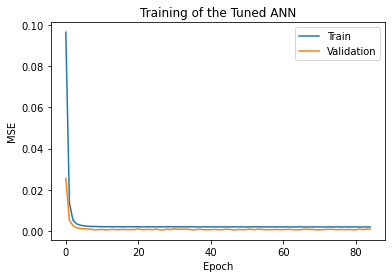

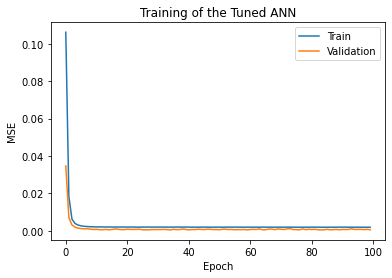

In [10]:
def visualising_data(hist, name):
    plt.title('Training of the Tuned ANN')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()
visualising_data(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results.svg')
visualising_data(history, '/Users/jackkelly/Desktop/Building_Model/Figures/full_epochs_results.svg')

In [11]:
# shows weights of the ANN
# print(hypermodel.weights)
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 174)               7308      
_________________________________________________________________
dropout (Dropout)            (None, 174)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                7000      
Total params: 14,308
Trainable params: 14,308
Non-trainable params: 0
_________________________________________________________________


In [12]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

# Transfer Learning

In [13]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
#     hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid'))
#     model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [14]:
test_data_numbers = [200, 400, 800, 1200, 1600, 2000, 2400]
timings = []
old_model_results = []
N_channels = 40
def number_of_channels(ending):
    TL_model_results = []
    for i in range(len(test_data_numbers)):
        model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')
        file_path = '/Users/jackkelly/Desktop/Building_Model/Data/' + str(test_data_numbers[i]) + '_data_points_train_val' + ending + '.csv'
        X_scale, Y_scale = processing_data(N_channels, file_path)
        X_train, X_val, Y_train, Y_val = train_test_split(X_scale, Y_scale, test_size=0.2)
        file_path = '/Users/jackkelly/Desktop/Building_Model/Data/' + str(test_data_numbers[i]) + '_data_points_test' + ending + '.csv'
        X_test, Y_test = processing_data(N_channels, file_path)
        print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
        start_time = time.time()
        # new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
        new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, shuffle=True, verbose=0)
        training_time = time.time() - start_time
        timings.append(training_time)
        # evaluating transfer-learned model
        eval_result = model.evaluate(X_test, Y_test, verbose=0)[1]
        # evaluating OLD model with new data
        hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
        TL_model_results.append(eval_result)
        old_model_results.append(hypermodel_result)
    return TL_model_results
TL_model_results_longer = number_of_channels('')
TL_model_results_shorter = number_of_channels('_shorter')
print(TL_model_results_longer)
print(TL_model_results_shorter)

(160, 41) (40, 41) (200, 41) (160, 40) (40, 40) (200, 40)
(320, 41) (80, 41) (400, 41) (320, 40) (80, 40) (400, 40)
(640, 41) (160, 41) (800, 41) (640, 40) (160, 40) (800, 40)
(960, 41) (240, 41) (1200, 41) (960, 40) (240, 40) (1200, 40)
(1280, 41) (320, 41) (1600, 41) (1280, 40) (320, 40) (1600, 40)
(1600, 41) (400, 41) (2000, 41) (1600, 40) (400, 40) (2000, 40)
(1920, 41) (480, 41) (2400, 41) (1920, 40) (480, 40) (2400, 40)
(160, 41) (40, 41) (200, 41) (160, 40) (40, 40) (200, 40)
(320, 41) (80, 41) (400, 41) (320, 40) (80, 40) (400, 40)
(640, 41) (160, 41) (800, 41) (640, 40) (160, 40) (800, 40)
(960, 41) (240, 41) (1200, 41) (960, 40) (240, 40) (1200, 40)
(1280, 41) (320, 41) (1600, 41) (1280, 40) (320, 40) (1600, 40)
(1600, 41) (400, 41) (2000, 41) (1600, 40) (400, 40) (2000, 40)
(1920, 41) (480, 41) (2400, 41) (1920, 40) (480, 40) (2400, 40)
[0.013727353, 0.0036353427, 0.001390177, 0.0012351352, 0.0012432613, 0.0011823494, 0.0010846168]
[0.01271413, 0.003290153, 0.0012931651, 0.0

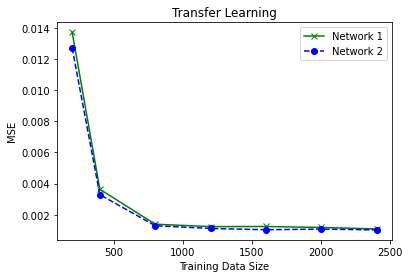

In [15]:
plt.title('Transfer Learning')
plt.plot(test_data_numbers, TL_model_results_longer, label='Network 1', marker='x', color='g')
plt.plot(test_data_numbers, TL_model_results_shorter, label='Network 2', marker='o', color='b', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Training Data Size')
plt.legend()
plt.savefig('transfer_learning.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Creating CDF Plot

In [ ]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test = build_model(N_channels, file_path)

In [ ]:
# name = '/Users/jackkelly/Desktop/Building_Model/Figures/Comparison.png'
# plt.title('Comparison of new and old ANN model')
# plt.plot(hypermodel_hist.history['mean_squared_error'], label='[Trained ANN] Train')
# plt.plot(hypermodel_hist.history['val_mean_squared_error'], label='[Trained ANN] Validation')
# plt.plot(hist.history['val_mean_squared_error'], label='[Non-tuned ANN] Validation')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.savefig(name)
# plt.show()

predictions = model.predict(X_test)
# mse = mean_squared_error(predictions, Y_test)
mean_squared_error_store = []
for i in range(3000):
    mean_squared_error_store.append(mean_squared_error(predictions[i], Y_test[i]))
x = np.sort(mean_squared_error_store)
y = np.arange(1, len(x)+1) / len(x)

predictions_hyper = hypermodel.predict(X_test)
# mse = mean_squared_error(predictions, Y_test)
mean_squared_error_store_hyper = []
for i in range(3000):
    mean_squared_error_store_hyper.append(mean_squared_error(predictions_hyper[i], Y_test[i]))
x_hyper = np.sort(mean_squared_error_store_hyper)
y_hyper = np.arange(1, len(x_hyper)+1) / len(x_hyper)


# 500 elements in mseArray so 90th percentile is 450th element
print('90th percentile mse = ', x[2700],'dB')
mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color='blue', label='Non-Tuned')
mse_ecdf = plt.plot(x_hyper, y_hyper, marker='*', linestyle='none', color='green', label='Tuned')
plt.title('Cumulative Distribution Function Plot')
plt.xlabel('MSE')
plt.ylabel('CDF')
plt.legend()
plt.savefig('CDF_initial_ann.png')
plt.show()

In [ ]:
best_hps.__dict__

# Raman Testing

In [16]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data.csv'
df = pd.read_csv(file_path)
dataset = pd.DataFrame(df)
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data2.csv'
df2 = pd.read_csv(file_path)
dataset2 = pd.DataFrame(df2)
df_tot = pd.concat([dataset, dataset2],ignore_index=True)
dataset3 = df_tot.values
X = dataset3[:,0:N_channels+1]
# channel SNRs
Y = dataset3[:,N_channels+1:2*N_channels+1]
X, Y = shuffle(X, Y)
# scaling between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
Y = min_max_scaler.fit_transform(Y)

In [17]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')
raman_hist = model.fit(X, Y, validation_split=0.2, epochs=150, shuffle=True, verbose=2)

Train on 96 samples, validate on 24 samples
Epoch 1/150
96/96 - 1s - loss: 0.2439 - mean_squared_error: 0.2436 - val_loss: 0.2238 - val_mean_squared_error: 0.2235
Epoch 2/150
96/96 - 0s - loss: 0.2313 - mean_squared_error: 0.2309 - val_loss: 0.2155 - val_mean_squared_error: 0.2151
Epoch 3/150
96/96 - 0s - loss: 0.2190 - mean_squared_error: 0.2186 - val_loss: 0.2077 - val_mean_squared_error: 0.2073
Epoch 4/150
96/96 - 0s - loss: 0.2055 - mean_squared_error: 0.2051 - val_loss: 0.2005 - val_mean_squared_error: 0.2001
Epoch 5/150
96/96 - 0s - loss: 0.1976 - mean_squared_error: 0.1973 - val_loss: 0.1938 - val_mean_squared_error: 0.1934
Epoch 6/150
96/96 - 0s - loss: 0.1858 - mean_squared_error: 0.1855 - val_loss: 0.1876 - val_mean_squared_error: 0.1873
Epoch 7/150
96/96 - 0s - loss: 0.1762 - mean_squared_error: 0.1758 - val_loss: 0.1819 - val_mean_squared_error: 0.1816
Epoch 8/150
96/96 - 0s - loss: 0.1696 - mean_squared_error: 0.1693 - val_loss: 0.1767 - val_mean_squared_error: 0.1764
Epoc

Epoch 69/150
96/96 - 0s - loss: 0.0315 - mean_squared_error: 0.0311 - val_loss: 0.0657 - val_mean_squared_error: 0.0654
Epoch 70/150
96/96 - 0s - loss: 0.0319 - mean_squared_error: 0.0316 - val_loss: 0.0650 - val_mean_squared_error: 0.0646
Epoch 71/150
96/96 - 0s - loss: 0.0308 - mean_squared_error: 0.0304 - val_loss: 0.0643 - val_mean_squared_error: 0.0639
Epoch 72/150
96/96 - 0s - loss: 0.0311 - mean_squared_error: 0.0307 - val_loss: 0.0636 - val_mean_squared_error: 0.0632
Epoch 73/150
96/96 - 0s - loss: 0.0302 - mean_squared_error: 0.0299 - val_loss: 0.0629 - val_mean_squared_error: 0.0626
Epoch 74/150
96/96 - 0s - loss: 0.0292 - mean_squared_error: 0.0288 - val_loss: 0.0623 - val_mean_squared_error: 0.0619
Epoch 75/150
96/96 - 0s - loss: 0.0287 - mean_squared_error: 0.0283 - val_loss: 0.0616 - val_mean_squared_error: 0.0613
Epoch 76/150
96/96 - 0s - loss: 0.0278 - mean_squared_error: 0.0275 - val_loss: 0.0610 - val_mean_squared_error: 0.0606
Epoch 77/150
96/96 - 0s - loss: 0.0279 -

Epoch 137/150
96/96 - 0s - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0380 - val_mean_squared_error: 0.0377
Epoch 138/150
96/96 - 0s - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0378 - val_mean_squared_error: 0.0375
Epoch 139/150
96/96 - 0s - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0376 - val_mean_squared_error: 0.0373
Epoch 140/150
96/96 - 0s - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0374 - val_mean_squared_error: 0.0371
Epoch 141/150
96/96 - 0s - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0372 - val_mean_squared_error: 0.0369
Epoch 142/150
96/96 - 0s - loss: 0.0131 - mean_squared_error: 0.0127 - val_loss: 0.0370 - val_mean_squared_error: 0.0366
Epoch 143/150
96/96 - 0s - loss: 0.0134 - mean_squared_error: 0.0130 - val_loss: 0.0368 - val_mean_squared_error: 0.0364
Epoch 144/150
96/96 - 0s - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0366 - val_mean_squared_error: 0.0362
Epoch 145/150
96/96 - 0s - loss:

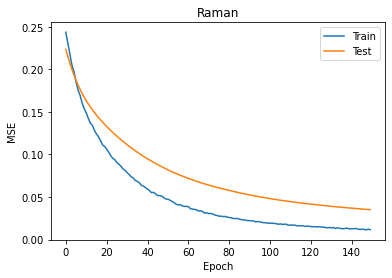

In [18]:
plt.title('Raman')
plt.plot(raman_hist.history['mean_squared_error'], label='Train')
plt.plot(raman_hist.history['val_mean_squared_error'], label='Test')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()